# Methods validation using simulations of transcription factor network

Compare methods
- Including latent nodes vs no latent nodes
- Imputation as part of model or outside of model

Accuracy
- Show accuracy of methods

In [1]:
# Load packages
from MScausality.causal_model.LVM import LVM
from MScausality.simulation.simulation import simulate_data
from MScausality.data_analysis.normalization import normalize
from MScausality.data_analysis.dataProcess import dataProcess

import pyro
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag

from y0.dsl import Variable
from eliater.regression import summary_statistics, estimate_probabilities, fit_regression, get_adjustment_set
from operator import attrgetter

from scipy.stats import linregress
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kohler.d/Library/CloudStorage/OneDrive-NortheasternUniversity/Northeastern/Research/Causal_Inference/packages/y0/src/y0/examples/__init__.py:1173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  asia_df = pd.read_csv(ASIA_PATH).replace({"yes": 1, "no": -1})


In [2]:
def get_std_error(
        graph,
        data,
        treatments,
        outcome,
        _adjustment_set=None):

    treatments = y0.graph._ensure_set(treatments)
    if _adjustment_set:
        adjustment_set = _adjustment_set
    else:
        adjustment_set, _ = get_adjustment_set(graph=graph, treatments=treatments, outcome=outcome)
    variable_set = adjustment_set.union(treatments).difference({outcome})
    variables = sorted(variable_set, key=attrgetter("name"))
    model = linregress(data[[v.name for v in variables]].values.flatten(), data[outcome.name].values)
    
    return model.stderr*np.sqrt(len(data))

def comparison(full_graph, 
               y0_graph, 
               coefficients, 
               int1, int2, 
               outcome,
               obs_data=None,
               training_obs=1000,
               alt_graph=None
               ):
    """
    Compare the results of the full graph with the y0 graph
    
    """

    ## Ground truth
    if obs_data is None:
        obs_data = pd.DataFrame(simulate_data(full_graph, coefficients=coefficients, 
                            add_feature_var=False, n=training_obs, seed=2)
                            ["Protein_data"])

    intervention_low = simulate_data(full_graph, coefficients=coefficients,
                                     intervention=int1, 
                                     add_feature_var=False, n=10000, seed=2)

    intervention_high = simulate_data(full_graph, coefficients=coefficients,
                                     intervention=int2, 
                                     add_feature_var=False, n=10000, seed=2)

    ## Eliator results
    if obs_data.isnull().values.any():
        imputer = KNNImputer(n_neighbors=3)

        # # Impute missing values (the result is a NumPy array, so we need to convert it back to a DataFrame)
        obs_data_eliator = obs_data.copy()
        obs_data_eliator = pd.DataFrame(imputer.fit_transform(obs_data_eliator), columns=obs_data.columns)
        # def impute_with_normal(df):
        #     for col in df.columns:
        #         missing = df[col].isnull()
        #         if missing.any():
        #             # Sample from normal distribution based on column mean and std
        #             df.loc[missing, col] = np.random.normal(df[col].mean(), df[col].std(), missing.sum())
        #     return df
        # obs_data_eliator = impute_with_normal(obs_data_eliator)
    else:
        obs_data_eliator = obs_data.copy()

    eliator_int_low = summary_statistics(
        y0_graph, obs_data_eliator,
        treatments={Variable(list(int1.keys())[0])},
        outcome=Variable(outcome),
        interventions={
            Variable(list(int1.keys())[0]): list(int1.values())[0]})

    eliator_int_high = summary_statistics(
        y0_graph, obs_data_eliator,
        treatments={Variable(list(int2.keys())[0])},
        outcome=Variable(outcome),
        interventions={
            Variable(list(int2.keys())[0]): list(int2.values())[0]})
    
    # eliator_std_error = get_std_error(
    #     y0_graph, obs_data_eliator, 
    #     treatments={Variable(list(int2.keys())[0])}, 
    #     outcome=Variable(outcome))


    ## MScausality results
    if alt_graph is None:
        alt_graph = y0_graph
    pyro.clear_param_store()

    transformed_data = normalize(obs_data, wide_format=True)
    input_data = transformed_data["df"]
    scale_metrics = transformed_data["adj_metrics"]

    lvm = LVM(input_data, alt_graph)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=10000)

    # lvm.intervention(int1, outcome)
    # mscausality_int_low = lvm.intervention_samples
    # lvm.intervention(int2, outcome)
    # mscausality_int_high = lvm.intervention_samples
    lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] - scale_metrics["mean"]) / scale_metrics["std"]}, outcome)
    mscausality_int_low = lvm.intervention_samples
    lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] - scale_metrics["mean"]) / scale_metrics["std"]}, outcome)
    mscausality_int_high = lvm.intervention_samples
    
    
    mscausality_int_low = (mscausality_int_low*scale_metrics["std"]) + scale_metrics["mean"]
    mscausality_int_high = (mscausality_int_high*scale_metrics["std"]) + scale_metrics["mean"]

    ## Comparison plots
    fig, ax = plt.subplots(3,1, figsize=(8,8))
    fig.tight_layout()
    
    ax[0].hist(intervention_low["Protein_data"][outcome], alpha=.75, bins=20)
    ax[0].hist(intervention_high["Protein_data"][outcome], alpha=.75, bins=20)
    ax[0].axvline(np.mean(intervention_low["Protein_data"][outcome]), 
                  color="darkblue", linestyle="dashed", lw=4)
    ax[0].axvline(np.mean(intervention_high["Protein_data"][outcome]), 
                  color="darkred", linestyle="dashed", lw=4)
    ax[0].set_title("Ground truth")

    ax[1].hist(np.random.normal(eliator_int_low.mean, 1, 10000), 
               alpha=.75, bins=20)
    ax[1].hist(np.random.normal(eliator_int_high.mean, 1, 10000), 
               alpha=.75, bins=20)
    ax[1].axvline(np.mean(intervention_low["Protein_data"][outcome]), 
                  color="darkblue", linestyle="dashed", lw=4)
    ax[1].axvline(np.mean(intervention_high["Protein_data"][outcome]), 
                  color="darkred", linestyle="dashed", lw=4)
    ax[1].set_title("Eliator")

    ax[2].hist(mscausality_int_low, alpha=.75, bins=20)
    ax[2].hist(mscausality_int_high, alpha=.75, bins=20)
    ax[2].axvline(np.mean(intervention_low["Protein_data"][outcome]), 
                  color="darkblue", linestyle="dashed", lw=4)
    ax[2].axvline(np.mean(intervention_high["Protein_data"][outcome]), 
                  color="darkred", linestyle="dashed", lw=4)
    ax[2].set_title("MScausality")

    ax[0].set_xlim(-10,10)
    ax[1].set_xlim(-10,10)
    ax[2].set_xlim(-10,10)

    result_df = pd.DataFrame({
        "Ground_truth": [np.mean(intervention_low["Protein_data"][outcome]), 
                         np.mean(intervention_high["Protein_data"][outcome])],
        "Ground_truth_std": [np.std(intervention_low["Protein_data"][outcome]), 
                             np.std(intervention_high["Protein_data"][outcome])],
        "Eliator": [eliator_int_low.mean, eliator_int_high.mean],
        # "Eliator_std": [eliator_std_error, eliator_std_error],
        "MScausality": [np.mean(np.array(mscausality_int_low)), 
                        np.mean(np.array(mscausality_int_high))],
        "MScausality_std": [np.std(np.array(mscausality_int_low)), 
                            np.std(np.array(mscausality_int_high))]
    })

    return result_df, lvm

    

# Latent variable model vs regression

## Simple Regression

In [3]:
def build_sr_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "MYC")
    
    return graph

def build_sr_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "MYC"]
    obs_nodes = ["IL6", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

In [4]:
sr_graph = build_sr_network()
y0_sr_graph = build_sr_admg(sr_graph)

In [5]:
## Coefficients for relations
# sr_coef = {'STAT3': {'intercept': 0, "error": 1},
#             'MYC': {'intercept': 2, "error": .25, 'STAT3': 1.}}
sr_coef = {'IL6': {'intercept': 8, "error": 1},
            'MYC': {'intercept': -6, "error": .25, 'IL6': 1.}}

simulating data...
simulating data...
simulating data...
Step 0: Loss = 1065.9144097473472
Step 100: Loss = -269.08605509996414
Step 200: Loss = -659.751949340105
Step 300: Loss = -822.4939948320389
Step 400: Loss = -910.8907623589039
Step 500: Loss = -996.0531293153763
Step 600: Loss = -1060.9197906255722
Step 700: Loss = -1100.954879373312
Step 800: Loss = -1145.829118669033
Step 900: Loss = -1144.914663285017
Step 1000: Loss = -1190.4298485517502
Step 1100: Loss = -1215.722734004259
Stopping early at step 1149 with loss -1211.1432645618916


,Ground_truth,Ground_truth_std,Eliator,Eliator_std,MScausality,MScausality_std
0,7.004485,0.251902,7.015879,0.233839,6.994071,0.265262
1,9.004485,0.251902,8.997016,0.233839,8.975492,0.260379


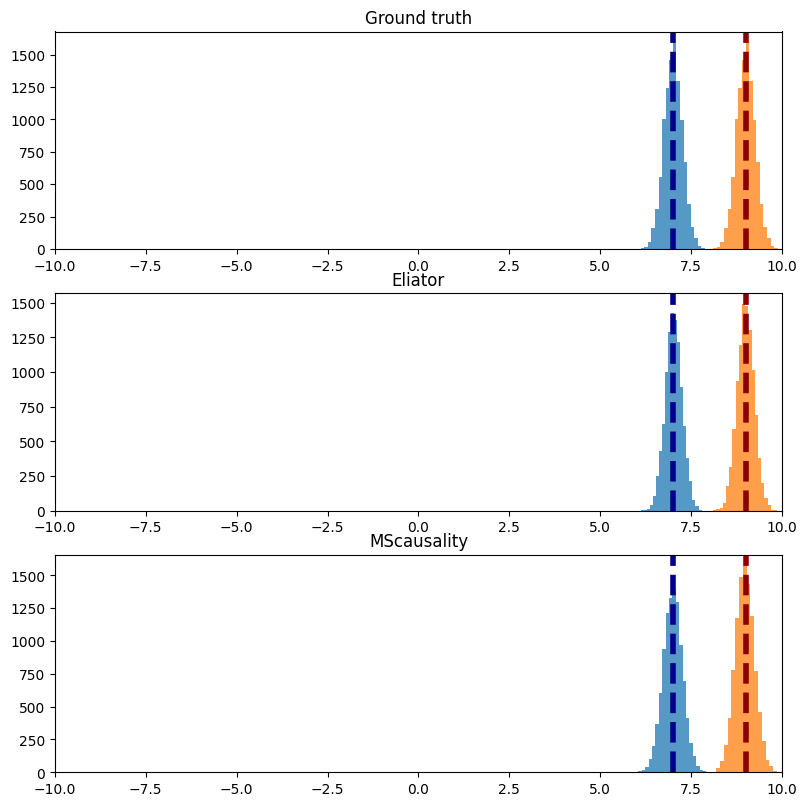

In [67]:
comparison(sr_graph, y0_sr_graph, sr_coef, {"IL6": 5}, 
           {"IL6": 7}, "MYC", training_obs=200)

## Mediator

In [3]:
def build_tf_med_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    return graph

def build_med_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

In [4]:
med_graph = build_tf_med_network()
y0_med_graph = build_med_admg(med_graph)

In [124]:
## Coefficients for relations
med_coef = {'IL6': {'intercept': 6, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25,  'IL6': 0.5},
              'MYC': {'intercept': -3, "error": .25, 'STAT3': 1.}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 814.0287779048085
Step 100: Loss = -182.0986661836505
Step 200: Loss = -470.6648276373744
Step 300: Loss = -598.0711401775479
Step 400: Loss = -661.077899383381
Step 500: Loss = -718.9144815206528
Step 600: Loss = -774.1813282519579
Step 700: Loss = -798.5461848974228
Step 800: Loss = -823.7201204001904
Stopping early at step 895 with loss -825.2973107397556


,Ground_truth,Ground_truth_std,Eliator,Eliator_std,MScausality,MScausality_std
0,2.602243,0.35274,2.733529,0.36933,2.527611,0.444577
1,4.602243,0.35274,4.658131,0.36933,4.518209,0.399787


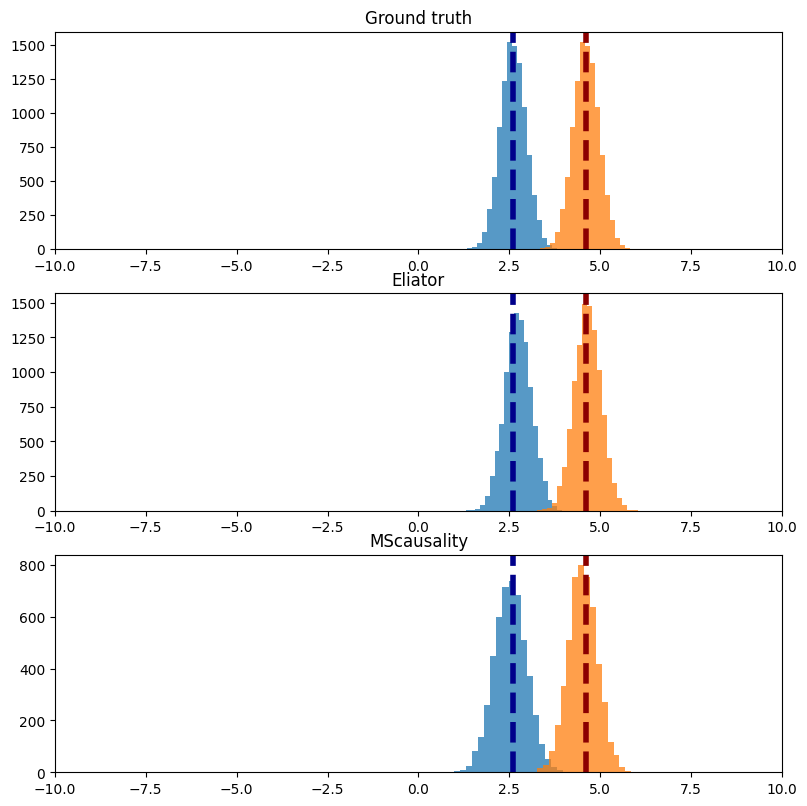

In [48]:
comparison(med_graph, y0_med_graph, med_coef, {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=100)

## Mediator with latent

In [49]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "STAT3")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_med_lat_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "MYC")

In [50]:
med_lat_graph = build_tf_med_lat_network()
y0_med_lat_graph = build_med_lat_admg(med_lat_graph)

In [51]:
## Coefficients for relations
med_lat_coef = {'IL6': {'intercept': 6, "error": 1.},
            'C1': {'intercept': 0, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5, 'C1': .35},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .35}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 1009.6254719626158
Step 100: Loss = -320.47797271609306
Step 200: Loss = -580.8953213989735
Step 300: Loss = -735.4455085992813
Step 400: Loss = -830.623497903347
Step 500: Loss = -877.2354270815849
Step 600: Loss = -895.4808497130871
Step 700: Loss = -959.2840018868446
Step 800: Loss = -991.0827164649963
Step 900: Loss = -1016.8952932357788
Step 1000: Loss = -1034.753680050373
Step 1100: Loss = -1058.7905599474907
Stopping early at step 1164 with loss -1049.1018074154854


,Ground_truth,Ground_truth_std,Eliator,Eliator_std,MScausality,MScausality_std
0,2.613218,0.788609,3.074163,0.842476,2.756216,0.905656
1,4.613218,0.788609,4.885856,0.842476,4.749307,0.912331


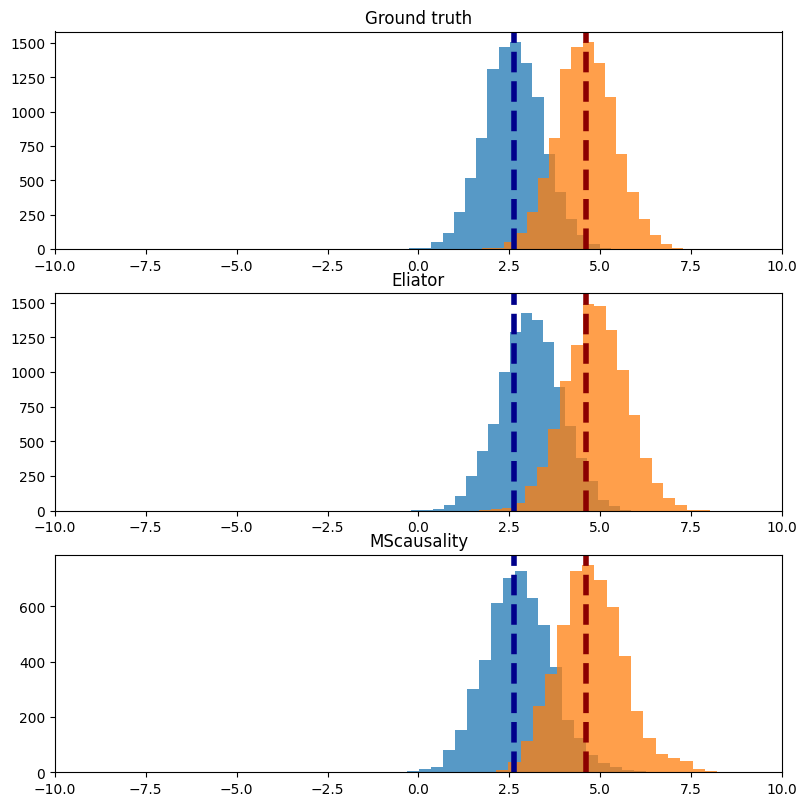

In [52]:
comparison(med_lat_graph, y0_med_lat_graph, med_lat_coef, {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=100)

## More latents!

In [53]:
def build_tf_med_more_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "M2")
    graph.add_edge("M2", "MYC")
    
    graph.add_edge("C1", "STAT3")
    graph.add_edge("C1", "MYC")
    graph.add_edge("C2", "M2")
    graph.add_edge("C2", "MYC")
    
    return graph

def build_med_more_lat_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "M2", "MYC", "C1", "C2"]
    obs_nodes = ["IL6", "STAT3", "M2", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

med_more_lat_graph = build_tf_med_more_lat_network()
y0_more_med_lat_graph = build_med_more_lat_admg(med_more_lat_graph)

## Coefficients for relations
med_more_lat_coef = {'IL6': {'intercept': 0, "error": 1.},
            'C1': {'intercept': 0, "error": 1.},
            'C2': {'intercept': 0, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5, 'C1': .35},
            'M2': {'intercept': 1.6, "error": .25, 'STAT3': 0.5, 'C2': .6},
            'MYC': {'intercept': 2, "error": .25, 'M2': 1., 'C1': .35, 'C2':.6}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 3937.622374652885
Step 100: Loss = -674.250563621521
Step 200: Loss = -1663.5362588763237
Step 300: Loss = -2117.512371689081
Step 400: Loss = -2355.837092667818
Step 500: Loss = -2531.7904413938522
Step 600: Loss = -2679.6769704520702
Step 700: Loss = -2794.6987269818783
Step 800: Loss = -2883.454954624176
Step 900: Loss = -2995.0013480186462
Step 1000: Loss = -3050.5600802004337
Step 1100: Loss = -3111.537637412548
Step 1200: Loss = -3187.653555572033
Step 1300: Loss = -3227.8199532926083
Step 1400: Loss = -3306.5716447234154
Step 1500: Loss = -3346.9880135059357
Step 1600: Loss = -3374.2827855944633
Step 1700: Loss = -3417.230492979288
Step 1800: Loss = -3467.203764051199
Step 1900: Loss = -3471.3239775896072
Step 2000: Loss = -3519.0474931299686
Step 2100: Loss = -3572.3859564960003
Step 2200: Loss = -3543.895445674658
Step 2300: Loss = -3613.5361619889736
Step 2400: Loss = -3665.850988805294
Step 2500: Loss = 

,Ground_truth,Ground_truth_std,Eliator,Eliator_std,MScausality,MScausality_std
0,3.897529,1.35684,3.813367,1.249237,3.414066,1.351712
1,4.897529,1.35684,4.629113,1.249237,4.946893,1.335427


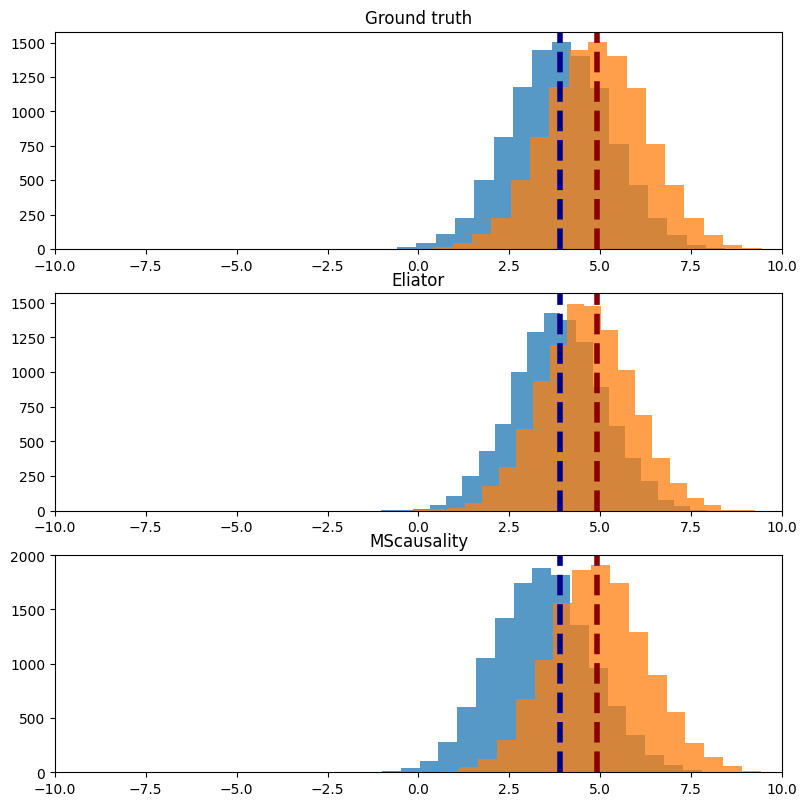

In [54]:
comparison(med_more_lat_graph, y0_more_med_lat_graph, med_more_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=250)

## Mediator with latent confounder

In [55]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "IL6")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

confound_lat_graph = build_tf_med_lat_network()
confound_lat_y0_graph = build_admg(confound_lat_graph)

## Coefficients for relations
confound_lat_coef = {
            'C1': {'intercept': 0, "error": 1.},
            'IL6': {'intercept': 0, "error": 1., 'C1': .9},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .9}
              }

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "STAT3")
alt_graph.add_directed_edge("STAT3", "MYC")
alt_graph.add_directed_edge("IL6", "MYC")
alt_graph.add_undirected_edge("IL6", "MYC")

In [56]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=None)

simulating data...
simulating data...
simulating data...


ValueError: No valid adjustment set found for IL6 -> MYC

simulating data...
simulating data...
simulating data...
Step 0: Loss = 17391.347883095965
Step 100: Loss = -240.22616556286812
Step 200: Loss = -3172.6533222198486
Stopping early at step 281 with loss -4229.448123335838
         parameter         mean         scale
0    IL6_intercept  0.027472159   0.042093765
1        IL6_scale    0.2558112    0.02109838
2  STAT3_intercept    1.6054231    0.00995552
3   STAT3_IL6_coef    0.4997218  0.0073701697
4      STAT3_scale    -1.394317   0.027122784
5    MYC_intercept    1.7927781   0.027407428
6   MYC_STAT3_coef     1.010574   0.015180261
7     MYC_IL6_coef   0.46519786   0.016857618
8        MYC_scale  -0.36957818   0.024572663


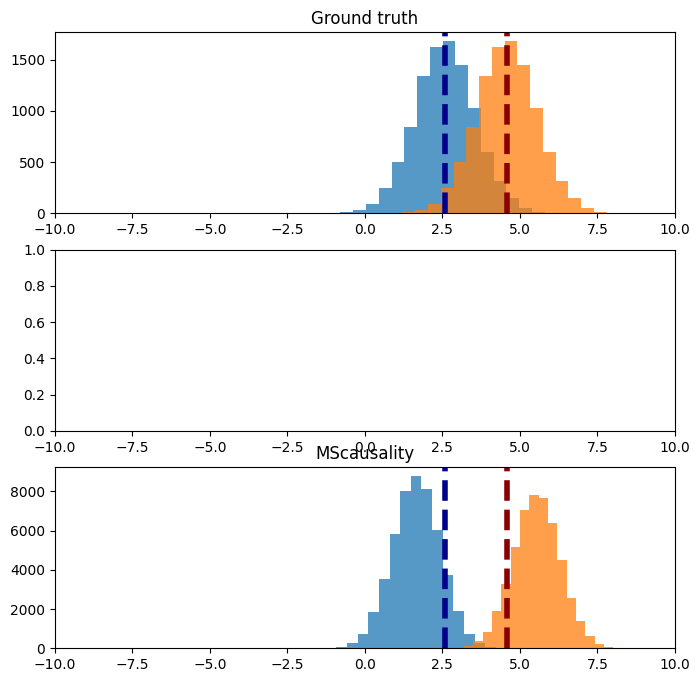

In [214]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=alt_graph)

- Why isnt Eliator working with mediator adj
- Fix MScausality model to work with mediator

In [225]:
obs_data = pd.DataFrame(simulate_data(confound_lat_graph, coefficients=confound_lat_coef, 
                        add_feature_var=False, n=1000, seed=2)["Protein_data"])

eliator_int_low = summary_statistics(
    confound_lat_y0_graph, obs_data,
    treatments={Variable('IL6'), Variable('STAT3')},
    outcome=Variable("MYC"),
    interventions={
        Variable('IL6'): -2})

simulating data...


MultipleTreatmentsNotImplementedError: 

In [236]:
    from y0.dsl import Variable, X, Y
    from eliater.frontdoor_backdoor import example1
    from eliater.regression import estimate_query_by_linear_regression

    graph = example1.graph
    data = example1.generate(100, seed=100)

    estimate_query_by_linear_regression(
        graph=graph,
        data=data,
        treatments={X},
        outcome=Y,
        query_type="ate"
    )

ValueError: No valid adjustment set found for X -> Y

In [234]:
graph.directed.edges

OutEdgeView([(X, M1), (M1, M2), (M2, Y)])

In [235]:
graph.undirected.edges

EdgeView([(X, Y)])

# Imputation as part of model vs before

## Simple regression

In [16]:
sr_data = simulate_data(sr_graph, coefficients=sr_coef, 
                        add_feature_var=True, n=50, seed=2)
# sr_data["Feature_data"].to_csv("../../data/methods_paper_data/tf_sim/simple_regression_feature_data.csv", index=False)

sr_data = dataProcess(sr_data["Feature_data"], normalization=False, sim_data=True)
# sr_data.head()

simulating data...
adding feature level data...
masking data...
TODO: imputation


simulating data...
simulating data...
Step 0: Loss = 267.30563405156136
Step 100: Loss = -85.59452500939369
Step 200: Loss = -177.94888138771057
Step 300: Loss = -229.06903541088104
Step 400: Loss = -234.04315993189812
Step 500: Loss = -231.4232148528099
Step 600: Loss = -263.307619869709
Step 700: Loss = -272.71268168091774
Stopping early at step 709 with loss -268.54645842313766


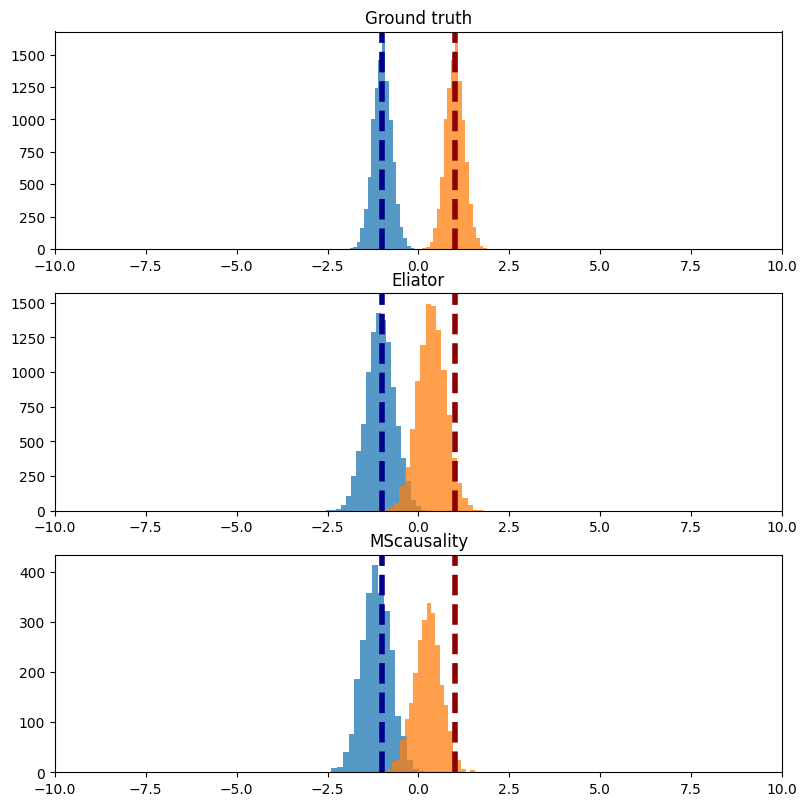

In [17]:
tf_comparison_result = comparison(sr_graph, y0_sr_graph, sr_coef, {"IL6": 5}, 
           {"IL6": 7}, "MYC", obs_data=sr_data)

In [23]:
lvm.priors

{'IL6': {'IL6_int': 0.6745453, 'IL6_scale': 0.30489009618759155},
 'MYC': {'MYC_IL6_coef': 0.7320269, 'MYC_int': -1.8679444}}

In [24]:
lvm.parameters

,parameter,mean,scale
0,MYC_int,-1.8870034,0.013721628
1,MYC_IL6_coef,0.7254792,0.019036459
2,MYC_scale,-2.1530302,0.059629492
3,IL6_int,0.6458226,0.04506009
4,IL6_scale,-1.2076197,0.10804795


In [11]:
from sklearn.linear_model import LinearRegression

temp_data = input_data.copy()
temp_data = temp_data.dropna()
lm = LinearRegression()
lm.fit(temp_data["MYC"].values.reshape(-1, 1), temp_data["IL6"].values)
lm.coef_

array([1.02033116])

In [22]:
pyro.clear_param_store()

obs_data=sr_data.loc[:, ["IL6", "MYC"]]   
transformed_data = normalize(obs_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

lvm = LVM(input_data, y0_sr_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=10000, patience=50)

# imp_data = lvm.imputed_data.copy()
# imp_data.loc[:, "intensity"] = np.where(imp_data["intensity"].isna(), imp_data["imp_mean"], imp_data["intensity"] )
# imp_data
# imp_data.pivot(columns="protein", values="intensity")

# # IL6	STAT3	

# il6_backdoor_data = input_data.loc[:, "IL6"]
# il6_backdoor_data = np.where(
#     np.isnan(il6_backdoor_data),
#     imp_data.loc[imp_data["protein"] == "IL6", "intensity"], 
#     il6_backdoor_data)

# stat3_backdoor_data = input_data.loc[:, "MYC"]
# stat3_backdoor_data = np.where(
#     np.isnan(stat3_backdoor_data),
#     imp_data.loc[imp_data["protein"] == "MYC", "intensity"], 
#     stat3_backdoor_data)

# fig, ax = plt.subplots()

# ax.scatter(il6_backdoor_data, stat3_backdoor_data)


Step 0: Loss = 267.30563405156136
Step 100: Loss = -85.59452500939369
Step 200: Loss = -177.94888138771057
Step 300: Loss = -229.06903541088104
Stopping early at step 350 with loss -229.2659018933773


In [164]:
from sklearn.linear_model import LinearRegression

def get_priors(data, root_nodes, leaf_nodes):
    """
    Get priors for the model
    
    """
    priors = {}
    for col in root_nodes:
        priors[col] = {"mean": data[col].mean(), "std": data[col].std()}

    for col, value in leaf_nodes.items():
        temp_data = data.copy()
        # temp_data = temp_data.dropna()
        lm = LinearRegression()
        lm.fit(temp_data[value], temp_data[col])
        temp = {}
        for v in value:
            temp[v] = lm.coef_[value.index(v)]
        temp["intercept"] = lm.intercept_
        priors[col] = temp
    return priors


In [165]:
priors = get_priors(test_data, ["IL6"], {"MYC": ["IL6"]})

TypeError: unhashable type: 'list'

In [21]:
priors = get_priors(sr_data, ["IL6"], {"MYC": ["IL6"]})
priors

{'IL6': {'mean': 8.314226243978569, 'std': 1.1150815875873736},
 'MYC': {'IL6': 0.8873957463352459, 'intercept': -4.027188731560763}}

In [24]:
import pyro.distributions as dist
import torch
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro import poutine

def test_model(data, priors):

    IL6_intercept = pyro.sample("IL6_intercept", dist.Normal(priors["IL6"]["mean"], 1))
    IL6_scale = pyro.sample("IL6_scale", dist.Exponential(1))

    MYC_intercept = pyro.sample("MYC_intercept", dist.Normal(priors["MYC"]["intercept"],1))
    MYC_IL6_coef = pyro.sample("MYC_IL6_coef", dist.Normal(priors["MYC"]["IL6"],.1))
    MYC_scale = pyro.sample("MYC_scale", dist.Exponential(1))
    
    with pyro.plate("obs", len(data["IL6"])):
        
        with poutine.mask(mask=data["IL6"] == 0):
            
            missing_values = pyro.sample(f"imp_IL6", 
                                         dist.Normal(IL6_intercept-IL6_scale, IL6_scale))
        
        data["IL6"] = data["IL6"].detach()
        data["IL6"][data["IL6"].isnan().bool()] = missing_values[data["IL6"].isnan().bool()]

        IL6 = pyro.sample("IL6", dist.Normal(
            IL6_intercept,
            IL6_scale
        ), obs=data["IL6"]
        )

        with poutine.mask(mask=data["MYC"] == 0):
            
            missing_values = pyro.sample(f"imp_MYC", 
                                         dist.Normal(
                                             MYC_intercept + IL6*MYC_IL6_coef-MYC_scale, 
                                             MYC_scale))
        
        data["MYC"] = data["MYC"].detach()
        data["MYC"][data["MYC"].isnan().bool()] = missing_values[data["MYC"].isnan().bool()]

        MYC = pyro.sample("MYC", dist.Normal(
            MYC_intercept + IL6*MYC_IL6_coef,
            MYC_scale
            ), obs=torch.tensor(data["MYC"])
            )

    return(IL6, MYC)

In [25]:
test_data = sr_data
transformed_data = normalize(test_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

priors = get_priors(input_data, ["IL6"], {"MYC": ["IL6"]})

test_data = {"IL6": torch.tensor(input_data.loc[:, "IL6"].values).float(),
             "MYC": torch.tensor(input_data.loc[:, "MYC"].values).float()}

pyro.clear_param_store()
optim = pyro.optim.ClippedAdam({'lr': .03})

guide = AutoNormal(test_model)

# setup the inference algorithm
svi = SVI(test_model, guide, optim, loss=Trace_ELBO())

for step in range(1000):
    loss = svi.step(test_data, priors)
    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss}")

params = [i for i in pyro.get_param_store().items()]
params = dict(params)
params = {key : value.detach() for key, value in params.items()}

Step 0: Loss = 6892.225121352822
Step 100: Loss = -132.05150285363197
Step 200: Loss = -296.1474642753601
Step 300: Loss = -365.7805679142475
Step 400: Loss = -412.0188255608082
Step 500: Loss = -454.91849610209465
Step 600: Loss = -480.203043282032
Step 700: Loss = -509.72511956095695
Step 800: Loss = -513.8733552992344
Step 900: Loss = -529.830473870039


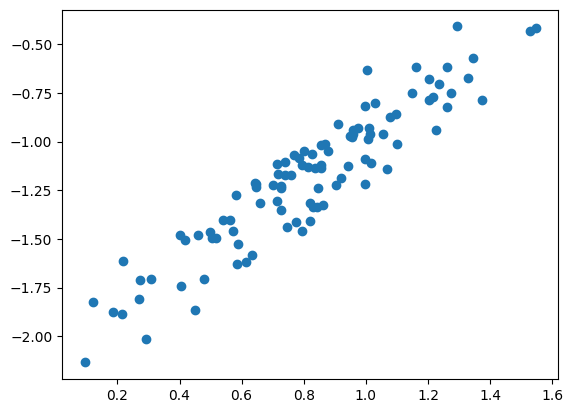

In [26]:
test_data["IL6"][test_data["IL6"] == 0] = params["AutoNormal.locs.imp_IL6"][params["AutoNormal.locs.imp_IL6"] != 0]
test_data["MYC"][test_data["MYC"] == 0] = params["AutoNormal.locs.imp_MYC"][params["AutoNormal.locs.imp_MYC"] != 0]

fig, ax = plt.subplots()
ax.scatter(test_data["IL6"].detach().numpy(), test_data["MYC"].detach().numpy())

In [27]:
test_data["IL6"]

tensor([0.7144, 1.0118, 1.5465, 0.8552, 0.4990, 1.0080, 0.6593, 0.8365, 1.2033,
        0.6127, 0.8452, 0.8251, 0.5727, 0.7943, 0.9212, 0.5387, 0.7383, 0.7698,
        0.6465, 0.4776, 0.4059, 0.7952, 0.1862, 0.7598, 1.5278, 0.0945, 0.8770,
        0.9562, 1.2600, 0.9965, 0.5831, 0.8424, 1.0090, 1.3462, 0.7461, 1.0792,
        0.2686, 1.3741, 1.2932, 0.7393, 1.0302, 0.8571, 0.5877, 0.8693, 0.2915,
        1.1497, 0.7253, 0.7270, 0.8195, 0.9755, 1.2351, 0.6474, 0.9986, 0.9088,
        0.2715, 0.5838, 0.7136, 0.8017, 0.8302, 0.9425, 0.2157, 0.8566, 0.6342,
        0.4003, 1.0034, 1.0682, 0.9969, 0.6417, 1.1012, 0.7252, 0.8628, 0.5049,
        1.3291, 0.4513, 0.8143, 1.0559, 0.2178, 0.4599, 0.7842, 0.8187, 1.0957,
        1.2258, 0.7183, 0.4171, 1.2623, 1.2165, 0.7005, 0.9502, 0.5174, 0.9597,
        1.0163, 0.9051, 1.2745, 0.3086, 1.1621, 0.9593, 0.7757, 1.2029, 0.1225,
        0.5632], grad_fn=<IndexPutBackward0>)

In [28]:
params

{'AutoNormal.locs.IL6_intercept': tensor(0.8424),
 'AutoNormal.scales.IL6_intercept': tensor(0.0307),
 'AutoNormal.locs.IL6_scale': tensor(-1.0918),
 'AutoNormal.scales.IL6_scale': tensor(0.0727),
 'AutoNormal.locs.MYC_intercept': tensor(-1.6290),
 'AutoNormal.scales.MYC_intercept': tensor(0.0472),
 'AutoNormal.locs.MYC_IL6_coef': tensor(1.0076),
 'AutoNormal.scales.MYC_IL6_coef': tensor(0.0097),
 'AutoNormal.locs.MYC_scale': tensor(-0.6015),
 'AutoNormal.scales.MYC_scale': tensor(0.0662),
 'AutoNormal.locs.imp_IL6': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [65]:
imp_data = params['AutoNormal.locs.imp_IL6']
# IL6	STAT3	

il6_backdoor_data = sr_data.loc[:, "IL6"]
il6_backdoor_data[il6_backdoor_data] = imp_data[il6_backdoor_data.isnan().bool()]

stat3_backdoor_data = sr_data.loc[:, "MYC"]

AttributeError: 'Series' object has no attribute 'isnan'

## Mediator

In [125]:
med_data = simulate_data(med_graph, coefficients=med_coef, 
                        add_feature_var=True, n=30, seed=2)
# med_data["Feature_data"].to_csv("../../data/methods_paper_data/tf_sim/mediator_feature_data.csv", index=False)
med_data = dataProcess(med_data["Feature_data"], normalization=False, sim_data=True)


simulating data...
adding feature level data...
masking data...
TODO: imputation


simulating data...
simulating data...
Step 0: Loss = 233.89206442353316
Step 100: Loss = -49.82337415218353
Step 200: Loss = -152.11511728167534
Step 300: Loss = -164.2670340538025
Step 400: Loss = -190.70366114377975
Stopping early at step 429 with loss -194.91390869021416


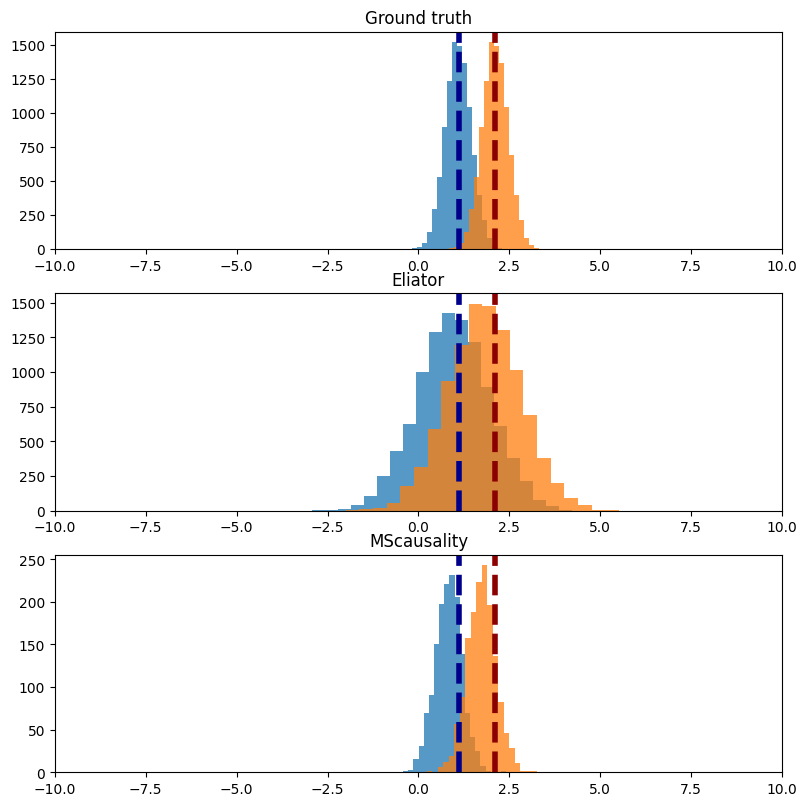

In [155]:
alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "STAT3")
alt_graph.add_directed_edge("STAT3", "MYC")

med_comparison_result = comparison(med_graph, y0_med_graph, med_coef, {"IL6": 5}, 
           {"IL6": 7}, "MYC", obs_data=med_data, alt_graph=alt_graph)

In [156]:
med_comparison_result[1].parameters

,parameter,mean,scale
0,STAT3_int,0.049891397,0.022020755
1,STAT3_IL6_coef,0.5480103,0.028000748
2,STAT3_scale,-1.9214485,0.13121448
3,MYC_int,-1.9742771,0.020086512
4,MYC_STAT3_coef,0.85502684,0.0329721
5,MYC_scale,-2.19631,0.102634184
6,IL6_int,0.707059,0.06025163
7,IL6_scale,-0.84023106,0.12228134


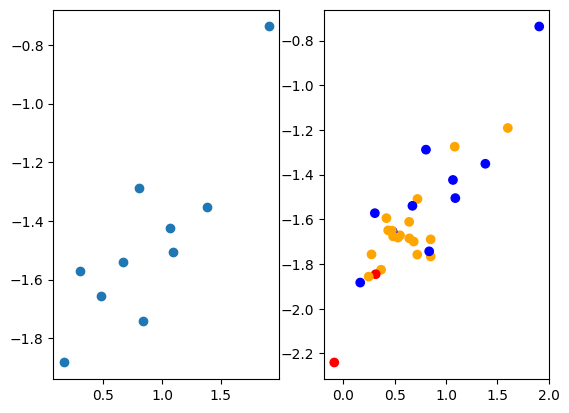

In [157]:
imp_data = med_comparison_result[1].imputed_data

il6_backdoor_data = imp_data.loc[imp_data["protein"] == "IL6"]
stat3_backdoor_data = imp_data.loc[imp_data["protein"] == "MYC"]

il6_backdoor_color = np.where(
    (il6_backdoor_data['imp_mean'].isna().values & stat3_backdoor_data['imp_mean'].isna().values), 
    "blue", np.where((il6_backdoor_data['intensity'].isna().values & stat3_backdoor_data['intensity'].isna().values), 
                     "red", "orange"))

il6_backdoor_data = np.where(
    il6_backdoor_data['imp_mean'].isna(),
    il6_backdoor_data['intensity'], 
    il6_backdoor_data['imp_mean'])

stat3_backdoor_data = np.where(
    stat3_backdoor_data['imp_mean'].isna(),
    stat3_backdoor_data['intensity'], 
    stat3_backdoor_data['imp_mean'])



fig, ax = plt.subplots(1,2)

transformed_data = normalize(med_data, wide_format=True)
input_data = transformed_data["df"]

ax[0].scatter(input_data.loc[:, "IL6"], input_data.loc[:, "MYC"])
ax[1].scatter(il6_backdoor_data, stat3_backdoor_data, color=il6_backdoor_color)

# ax[0].set_xlim(5,10)
# ax[1].set_xlim(5,10)
# ax[0].set_ylim(-2,9)
# ax[1].set_ylim(-2,9)

In [158]:
lm = LinearRegression()
lm.fit(input_data.dropna().loc[:, "IL6"].values.reshape(-1,1), input_data.dropna().loc[:, "MYC"].values)
print(lm.coef_)
lm = LinearRegression()
lm.fit(il6_backdoor_data.reshape(-1,1), stat3_backdoor_data)
lm.coef_

[0.51521274]


array([0.53906039])

In [159]:
import pyro.distributions as dist
import torch
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro import poutine

def test_model(data, priors):

    IL6_intercept = pyro.sample("IL6_intercept", dist.Normal(priors["IL6"]["IL6_int"], 1))
    IL6_scale = pyro.sample("IL6_scale", dist.Exponential(2))

    MYC_intercept = pyro.sample("MYC_intercept", dist.Normal(priors["MYC"]["MYC_int"],1))
    MYC_IL6_coef = pyro.sample("MYC_IL6_coef", dist.Normal(priors["MYC"]["MYC_IL6_coef"],.1))
    MYC_scale = pyro.sample("MYC_scale", dist.Exponential(2))
    
    with pyro.plate("obs", len(data["IL6"])):

        IL6 = pyro.sample("IL6", dist.Normal(
            IL6_intercept,
            IL6_scale
        ), obs=data["IL6"]
        )


        MYC = pyro.sample("MYC", dist.Normal(
            MYC_intercept + IL6*MYC_IL6_coef,
            MYC_scale
        ), obs=torch.tensor(data["MYC"])
        )

    return(IL6, MYC)

In [161]:
med_comparison_result[1].priors

{'IL6': {'IL6_int': 0.75400496, 'IL6_scale': 0.4780404269695282},
 'STAT3': {'STAT3_IL6_coef': 0.49036285, 'STAT3_int': 0.14283288},
 'MYC': {'MYC_STAT3_coef': 1.0548793, 'MYC_int': -2.0710645}}

In [160]:
test_data = {"IL6": torch.tensor(il6_backdoor_data).float(),
             "MYC": torch.tensor(stat3_backdoor_data).float()}

priors = get_priors(test_data, ["IL6"], {"MYC": ["IL6"]})

pyro.clear_param_store()
optim = pyro.optim.ClippedAdam({'lr': .03})

guide = AutoNormal(test_model)

# setup the inference algorithm
svi = SVI(test_model, guide, optim, loss=Trace_ELBO())

for step in range(1000):
    loss = svi.step(test_data, priors)
    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss}")

params = [i for i in pyro.get_param_store().items()]
params = dict(params)
params = {key : value.detach() for key, value in params.items()}

KeyError: 'MYC_IL6_coef'

In [154]:
params

{'AutoNormal.locs.IL6_intercept': tensor(0.7496),
 'AutoNormal.scales.IL6_intercept': tensor(0.0690),
 'AutoNormal.locs.IL6_scale': tensor(-0.8782),
 'AutoNormal.scales.IL6_scale': tensor(0.1288),
 'AutoNormal.locs.MYC_intercept': tensor(-1.9418),
 'AutoNormal.scales.MYC_intercept': tensor(0.0161),
 'AutoNormal.locs.MYC_IL6_coef': tensor(0.5173),
 'AutoNormal.scales.MYC_IL6_coef': tensor(0.0273),
 'AutoNormal.locs.MYC_scale': tensor(-2.1396),
 'AutoNormal.scales.MYC_scale': tensor(0.1145)}

## Mediator with latent

In [20]:
med_lat_data = simulate_data(med_lat_graph, coefficients=med_lat_coef, 
                        add_feature_var=True, n=30, seed=2)
med_lat_data["Feature_data"].to_csv("../../data/methods_paper_data/tf_sim/mediator_latent_feature_data.csv", index=False)

simulating data...
adding feature level data...
masking data...


In [21]:
med_lat_data = pd.read_csv("../../data/methods_paper_data/tf_sim/mediator_latent_protein_data.csv")
med_lat_data.head()

,C1,IL6,MYC,STAT3
0,0.209509,5.334102,6.720247,5.024507
1,0.473378,3.957424,5.544299,NaN
2,2.864700,4.909112,7.928784,5.498423
3,1.505076,4.692876,7.021710,5.033986
4,1.534168,4.841852,6.649496,5.350977


simulating data...
simulating data...
Step 0: Loss = 311.6264413446188
Step 100: Loss = -33.08746284246445
Step 200: Loss = -118.2949047088623
Step 300: Loss = -152.86597019433975
Stopping early at step 362 with loss -175.5459401011467


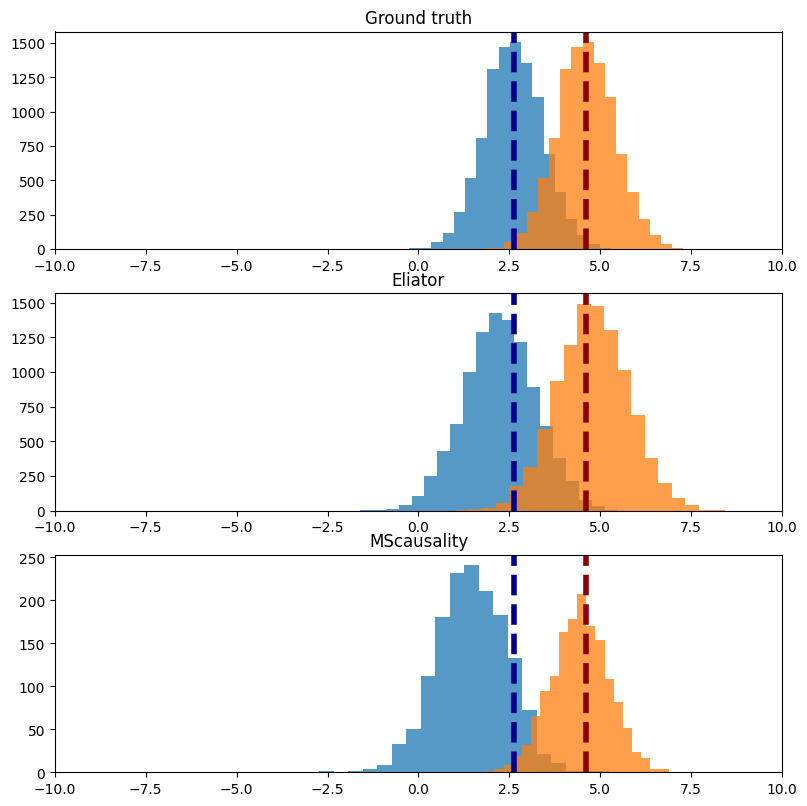

In [22]:
comparison(med_lat_graph, y0_med_lat_graph, med_lat_coef, {'IL6': -2}, {'IL6': 2}, "MYC", obs_data=med_lat_data)

## More latents!

In [ ]:
def build_tf_med_more_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "M2")
    graph.add_edge("M2", "MYC")
    
    graph.add_edge("C1", "STAT3")
    graph.add_edge("C1", "MYC")
    graph.add_edge("C2", "M2")
    graph.add_edge("C2", "MYC")
    
    return graph

def build_med_more_lat_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "M2", "MYC", "C1", "C2"]
    obs_nodes = ["IL6", "STAT3", "M2", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

med_more_lat_graph = build_tf_med_more_lat_network()
y0_more_med_lat_graph = build_med_more_lat_admg(med_more_lat_graph)

## Coefficients for relations
med_more_lat_coef = {'IL6': {'intercept': 0, "error": 1.},
            'C1': {'intercept': 0, "error": 1.},
            'C2': {'intercept': 0, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5, 'C1': .35},
            'M2': {'intercept': 1.6, "error": .25, 'STAT3': 0.5, 'C2': .6},
            'MYC': {'intercept': 2, "error": .25, 'M2': 1., 'C1': .35, 'C2':.6}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 7494.731795640662
Step 100: Loss = -45.733117043972015
Step 200: Loss = -1032.571386858821
Stopping early at step 242 with loss -1249.760004773736
          parameter          mean        scale
0   STAT3_intercept     1.3387204  0.028465286
1    STAT3_IL6_coef     0.5000562  0.021184882
2       STAT3_scale    -1.0697716   0.05024845
3      M2_intercept     1.1126058  0.035146754
4     M2_STAT3_coef    0.50191796  0.021457212
5          M2_scale   -0.82082474  0.043670386
6     MYC_intercept    0.34965262   0.04037617
7       MYC_M2_coef     1.4806646  0.016304327
8         MYC_scale    -0.9704578  0.043417733
9           IL6_int  -0.063298725  0.061388433
10        IL6_scale    0.09962243   0.04666827


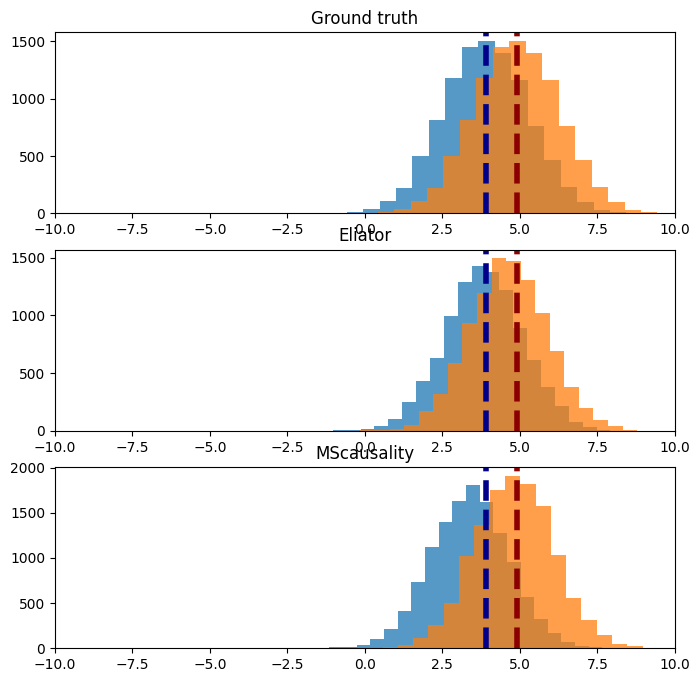

In [ ]:
comparison(med_more_lat_graph, y0_more_med_lat_graph, med_more_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=250)

## Mediator with latent confounder

In [ ]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "IL6")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

confound_lat_graph = build_tf_med_lat_network()
confound_lat_y0_graph = build_admg(confound_lat_graph)

## Coefficients for relations
confound_lat_coef = {
            'C1': {'intercept': 0, "error": 1.},
            'IL6': {'intercept': 0, "error": 1., 'C1': .9},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .9}
              }

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "STAT3")
alt_graph.add_directed_edge("STAT3", "MYC")
alt_graph.add_directed_edge("IL6", "MYC")
alt_graph.add_undirected_edge("IL6", "MYC")

simulating data...
simulating data...
simulating data...
Step 0: Loss = 17449.434643259272
Step 100: Loss = -173.7238034158945
Step 200: Loss = -3133.6745622754097
Step 300: Loss = -4478.32141533494
Step 400: Loss = -5276.433055818081
Stopping early at step 437 with loss -5386.4661369249225
         parameter         mean         scale
0    IL6_intercept  -0.71887374   0.032753155
1        IL6_scale   0.08588841   0.023160635
2  STAT3_intercept     1.592915   0.008527665
3   STAT3_IL6_coef   0.49829665  0.0068366504
4      STAT3_scale   -1.3429059    0.02309161
5    MYC_intercept    0.7428574    0.02055692
6   MYC_STAT3_coef    1.5313585   0.013135699
7        MYC_scale  -0.40708688   0.022808366


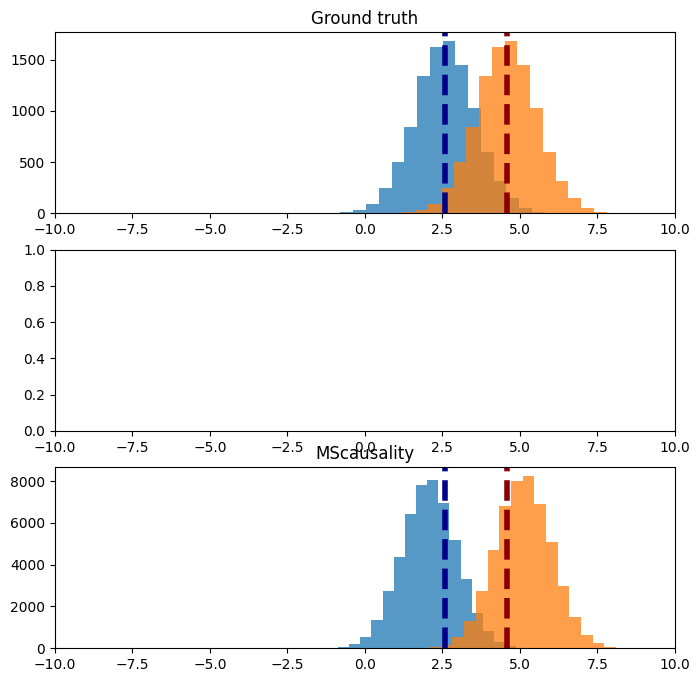

In [ ]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=None)

## Block backdoor path

In [83]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "IL6")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

confound_lat_graph = build_tf_med_lat_network()
confound_lat_y0_graph = build_admg(confound_lat_graph)

## Coefficients for relations
confound_lat_coef = {
            'C1': {'intercept': 0, "error": 1.},
            'IL6': {'intercept': 5, "error": 1., 'C1': .9},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .9}
              }

alt_graph = y0.graph.NxMixedGraph()
# alt_graph.add_directed_edge("IL6", "STAT3")
alt_graph.add_directed_edge("STAT3", "MYC")
alt_graph.add_directed_edge("IL6", "MYC")
# alt_graph.add_undirected_edge("IL6", "MYC")

In [84]:
backdoor_data = simulate_data(confound_lat_graph, coefficients=confound_lat_coef, 
                        add_feature_var=True, n=200, seed=2)

backdoor_data = dataProcess(backdoor_data["Feature_data"], 
                            normalization=False, sim_data=True)
backdoor_data

simulating data...
adding feature level data...
masking data...
TODO: imputation


,C1,IL6,STAT3,MYC
0,NaN,3.849136,3.023284,4.870304
1,NaN,7.291194,5.026927,8.537654
2,1.383520,6.315639,4.110052,6.176982
3,NaN,3.256050,3.234324,4.348875
4,1.368106,5.083615,3.885123,6.019732
...,...,...,...,...
195,1.460012,NaN,3.576364,5.982780
196,NaN,4.692151,3.724442,5.893375
197,NaN,6.257573,4.572150,7.356877
198,NaN,NaN,3.141383,3.381706


In [85]:
confound_lat_y0_graph.directed.edges

OutEdgeView([(IL6, STAT3), (STAT3, MYC)])

simulating data...
simulating data...
Step 0: Loss = 1457.394250933081
Step 100: Loss = -186.822691321373
Step 200: Loss = -648.4208578169346
Step 300: Loss = -866.0468986034393
Step 400: Loss = -1018.0379968583584
Step 500: Loss = -1100.8160584568977
Step 600: Loss = -1184.4179103076458
Step 700: Loss = -1227.6971147060394
Step 800: Loss = -1282.6849496364594
Step 900: Loss = -1366.8520621955395
Step 1000: Loss = -1341.2298638224602
Step 1100: Loss = -1415.5398996174335
Step 1200: Loss = -1433.4062115550041
Step 1300: Loss = -1468.170976370573
Step 1400: Loss = -1473.4719254374504
Step 1500: Loss = -1505.7598392665386
Stopping early at step 1559 with loss -1511.5901008844376


(   Ground_truth  Ground_truth_std   Eliator  MScausality  MScausality_std
 0     -0.014369          0.933575 -0.091970    -4.355451         0.807246
 1      3.985631          0.933575  4.007542     2.571075         0.791071,
 <MScausality.causal_model.LVM.LVM at 0x7f05c6ea6c20>)

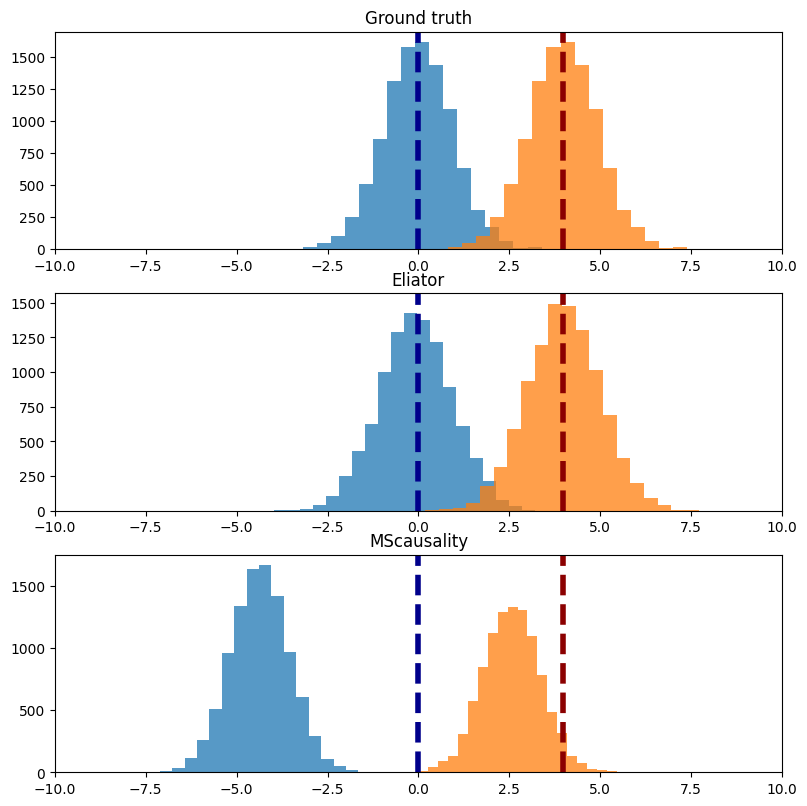

In [86]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'STAT3': -2}, {'STAT3': 2}, "MYC",
           obs_data=backdoor_data.loc[:, ["IL6", "STAT3", "MYC"]],
           alt_graph=alt_graph)

Step 0: Loss = 1568.3450834164396
Step 100: Loss = -64.54543578624725
Step 200: Loss = -384.70261508226395
Step 300: Loss = -540.9873056411743
Step 400: Loss = -651.0425806045532
Step 500: Loss = -688.1589269638062
Step 600: Loss = -751.9173384606838
Step 700: Loss = -777.8502241075039
Step 800: Loss = -827.0148249268532
Step 900: Loss = -872.3645390570164
Step 1000: Loss = -873.8795014023781
Stopping early at step 1054 with loss -906.3438519239426


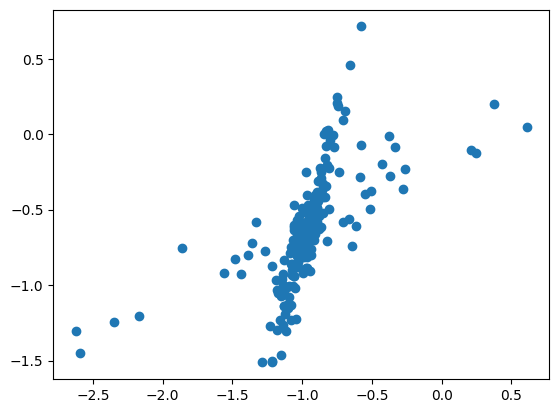

In [68]:
pyro.clear_param_store()

obs_data=backdoor_data.loc[:, ["IL6", "STAT3", "MYC"]]   
transformed_data = normalize(obs_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

lvm = LVM(input_data, alt_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=10000)

imp_data = lvm.imputed_data.copy()
imp_data.loc[:, "intensity"] = np.where(imp_data["intensity"].isna(), imp_data["imp_mean"], imp_data["intensity"] )
imp_data
imp_data.pivot(columns="protein", values="intensity")

# IL6	STAT3	

il6_backdoor_data = input_data.loc[:, "IL6"]
il6_backdoor_data = np.where(
    np.isnan(il6_backdoor_data),
    imp_data.loc[imp_data["protein"] == "IL6", "intensity"], 
    il6_backdoor_data)

stat3_backdoor_data = input_data.loc[:, "STAT3"]
stat3_backdoor_data = np.where(
    np.isnan(stat3_backdoor_data),
    imp_data.loc[imp_data["protein"] == "STAT3", "intensity"], 
    stat3_backdoor_data)

fig, ax = plt.subplots()

ax.scatter(il6_backdoor_data, stat3_backdoor_data)


In [69]:
lvm.priors

{'IL6': {'IL6_int': -0.90906525, 'IL6_scale': 0.7112913727760315},
 'STAT3': {'STAT3_IL6_coef': 0.46087646, 'STAT3_int': -0.13026413},
 'MYC': {'MYC_STAT3_coef': 1.9089764, 'MYC_int': 1.9032333}}

In [70]:
lvm.parameters

,parameter,mean,scale
0,STAT3_int,-0.15111136,0.01623045
1,STAT3_IL6_coef,0.5184882,0.019016657
2,STAT3_scale,-1.181629,0.045455165
3,MYC_int,1.8314608,0.02951921
4,MYC_STAT3_coef,1.9311352,0.039114647
5,MYC_scale,-0.73560643,0.046574727
6,IL6_int,-0.9598334,0.016400391
7,IL6_scale,-1.0638295,0.030524513


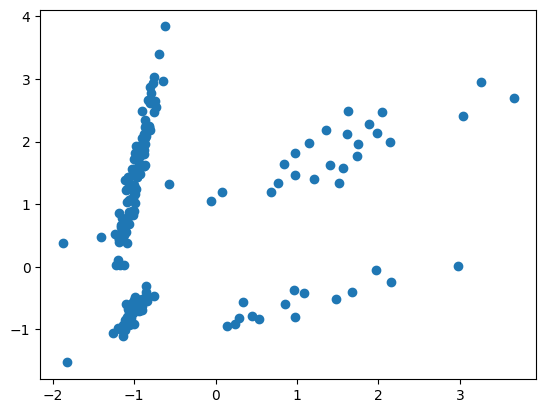

In [30]:
imp_data = lvm.imputed_data.copy()
imp_data.loc[:, "intensity"] = np.where(imp_data["intensity"].isna(), imp_data["imp_mean"], imp_data["intensity"] )
imp_data
imp_data.pivot(columns="protein", values="intensity")

# IL6	STAT3	

il6_backdoor_data = backdoor_data.loc[:, "IL6"]
il6_backdoor_data = np.where(
    np.isnan(il6_backdoor_data),
    imp_data.loc[imp_data["protein"] == "IL6", "intensity"], 
    il6_backdoor_data)

stat3_backdoor_data = backdoor_data.loc[:, "STAT3"]
stat3_backdoor_data = np.where(
    np.isnan(stat3_backdoor_data),
    imp_data.loc[imp_data["protein"] == "STAT3", "intensity"], 
    stat3_backdoor_data)

fig, ax = plt.subplots()

ax.scatter(il6_backdoor_data, stat3_backdoor_data)

In [7]:
lvm.parameters

,parameter,mean,scale
0,IL6_intercept,-0.87122315,0.015320627
1,IL6_scale,-1.0687802,0.036016334
2,STAT3_intercept,-0.36849552,0.015067369
3,STAT3_IL6_coef,0.3051884,0.016511746
4,STAT3_scale,-1.1402926,0.03867514
5,MYC_intercept,1.6188532,0.026114687
6,MYC_STAT3_coef,1.645171,0.041211452
7,MYC_scale,-0.5933648,0.035510108


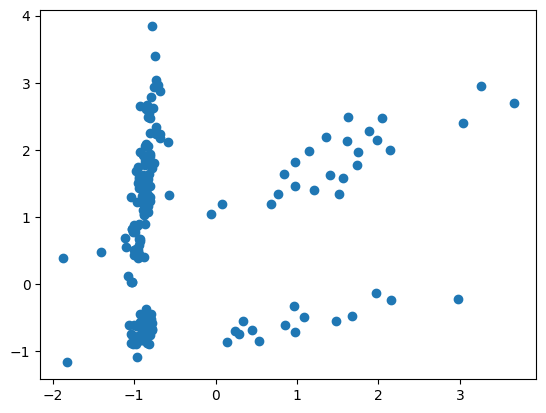

In [8]:
fig, ax = plt.subplots()

ax.scatter(il6_backdoor_data, stat3_backdoor_data)

In [11]:
import pyro.distributions as dist
import torch
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro import poutine

def test_model(data):

    IL6_intercept = pyro.sample("IL6_intercept", dist.Normal(0,1))
    IL6_scale = pyro.sample("IL6_scale", dist.Exponential(2.))

    STAT3_intercept = pyro.sample("STAT3_intercept", dist.Normal(0,1))
    STAT3_IL6_coef = pyro.sample("STAT3_IL6_coef", dist.Normal(0,1))
    STAT3_scale = pyro.sample("STAT3_scale", dist.Exponential(2.))

    MYC_intercept = pyro.sample("MYC_intercept", dist.Normal(0,1))
    MYC_STAT3_coef = pyro.sample("MYC_STAT3_coef", dist.Normal(0,1))
    MYC_scale = pyro.sample("MYC_scale", dist.Exponential(2.))
    
    with pyro.plate("obs", len(data["IL6"])):
        
        # with poutine.mask(mask=data["IL6"].isnan()):
            
        missing_values = pyro.sample(f"imp_IL6", 
                                         dist.Normal(IL6_intercept, IL6_scale))
        
        data["IL6"] = data["IL6"].detach()
        data["IL6"][data["IL6"].isnan().bool()] = missing_values[data["IL6"].isnan().bool()]

        IL6 = pyro.sample("IL6", dist.Normal(
            IL6_intercept,
            IL6_scale
        ), obs=data["IL6"]
        )

        missing_values = pyro.sample(f"imp_STAT3", 
                                         dist.Normal(STAT3_intercept + IL6*STAT3_IL6_coef, 
                                                     STAT3_scale))
        data["STAT3"] = data["STAT3"].detach()
        data["STAT3"][data["STAT3"].isnan().bool()] = missing_values[data["STAT3"].isnan().bool()]
    
        STAT3 = pyro.sample("Y", dist.Normal(
            STAT3_intercept + IL6*STAT3_IL6_coef,
            STAT3_scale
            ), obs=torch.tensor(data["STAT3"])
            )
        
        missing_values = pyro.sample(f"imp_MYC", 
                                         dist.Normal(MYC_intercept + STAT3*MYC_STAT3_coef, 
                                                     MYC_scale))
        data["MYC"] = data["MYC"].detach()
        data["MYC"][data["MYC"].isnan().bool()] = missing_values[data["MYC"].isnan().bool()]

        MYC = pyro.sample("MYC", dist.Normal(
            MYC_intercept + STAT3*MYC_STAT3_coef,
            MYC_scale
        ), obs=torch.tensor(data["MYC"])
        )

    return(IL6, STAT3, MYC)

In [12]:
test_data = backdoor_data
transformed_data = normalize(test_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

test_data = {"IL6": torch.tensor(input_data.loc[:, "IL6"].values).float(),
             "STAT3": torch.tensor(input_data.loc[:, "STAT3"].values).float(),
             "MYC": torch.tensor(input_data.loc[:, "MYC"].values).float()}

pyro.clear_param_store()
optim = pyro.optim.ClippedAdam({'lr': .03})

guide = AutoNormal(test_model)

# setup the inference algorithm
svi = SVI(test_model, guide, optim, loss=Trace_ELBO())

for step in range(500):
    loss = svi.step(test_data)
    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss}")

params = [i for i in pyro.get_param_store().items()]
params = dict(params)
params = {key : value.detach() for key, value in params.items()}

Step 0: Loss = 1810.7694639945403
Step 100: Loss = 521.5253160595894
Step 200: Loss = 505.7985244989395
Step 300: Loss = 503.8907201886177
Step 400: Loss = 508.5573207139969


In [13]:
params

{'AutoNormal.locs.IL6_intercept': tensor(-0.1660),
 'AutoNormal.scales.IL6_intercept': tensor(0.0257),
 'AutoNormal.locs.IL6_scale': tensor(-0.7664),
 'AutoNormal.scales.IL6_scale': tensor(0.0370),
 'AutoNormal.locs.STAT3_intercept': tensor(-0.2408),
 'AutoNormal.scales.STAT3_intercept': tensor(0.0247),
 'AutoNormal.locs.STAT3_IL6_coef': tensor(0.1108),
 'AutoNormal.scales.STAT3_IL6_coef': tensor(0.0414),
 'AutoNormal.locs.STAT3_scale': tensor(-0.8550),
 'AutoNormal.scales.STAT3_scale': tensor(0.0330),
 'AutoNormal.locs.MYC_intercept': tensor(1.0566),
 'AutoNormal.scales.MYC_intercept': tensor(0.0370),
 'AutoNormal.locs.MYC_STAT3_coef': tensor(1.1630),
 'AutoNormal.scales.MYC_STAT3_coef': tensor(0.0682),
 'AutoNormal.locs.MYC_scale': tensor(-0.2736),
 'AutoNormal.scales.MYC_scale': tensor(0.0366),
 'AutoNormal.locs.imp_IL6': tensor([-0.1784, -0.0291, -0.0719, -0.1846, -0.1462, -0.2017, -0.1000, -0.1555,
         -0.1592, -0.1063, -0.0879, -0.1549, -0.1883, -0.0840, -0.0550, -0.2652,
  

# Benchmarking analysis (many sims)

### Simple Regression

In [9]:
with open("../../two_node_result.pickle", "rb") as f:
    two_node_benchmark = pickle.load(f)

In [12]:
two_node_benchmark['20']

{'eliate_ate': [1.0752565127704647,
  1.5704766727273387,
  1.7821243392879134,
  1.3974054392414745,
  1.799007324575116,
  1.1096020253471304,
  0.6827775208968676,
  1.8291177259237033,
  1.988716743323458,
  0.3557707272570261,
  1.8871990842936348,
  1.5736256710453145,
  1.0404717021906356,
  1.5600297169280195,
  1.30291775033536,
  1.7843134120200865,
  1.7744313149045374,
  1.0322642096949994,
  1.2825849183217395,
  0.5077879351698849],
 'mscausality_ate': [0.9459835,
  1.4478762,
  1.7229364,
  1.1028792,
  1.6007419,
  0.8809229,
  1.4318265,
  2.0230184,
  2.037036,
  -2.5896244,
  1.8651867,
  1.3411452,
  1.0110424,
  1.5594699,
  1.4517523,
  1.7741507,
  1.6973976,
  1.0930493,
  1.6114256,
  -0.44921064],
 'eliate_var': [0.4868877460196482,
  0.3222610181875257,
  0.27332247966971296,
  0.4385935191029893,
  0.4351163663206424,
  0.5693093944363293,
  0.7031718284764016,
  0.3680326627227409,
  0.2323470662203625,
  0.23137512546593134,
  0.34955945714824166,
  0.4124

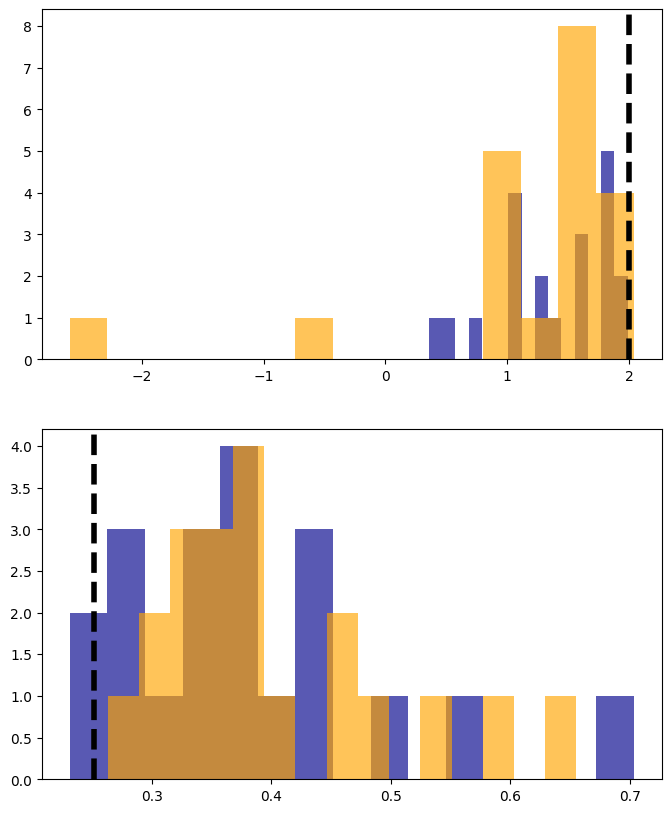

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(two_node_benchmark['20']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(two_node_benchmark['20']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(tf_comparison_result.loc[1, "Ground_truth"] - tf_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(two_node_benchmark['20']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(two_node_benchmark['20']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(tf_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

In [75]:
with open("../../data/methods_paper_data/tf_sim/two_node_result.pickle", "rb") as f:
    two_node_benchmark = pickle.load(f)

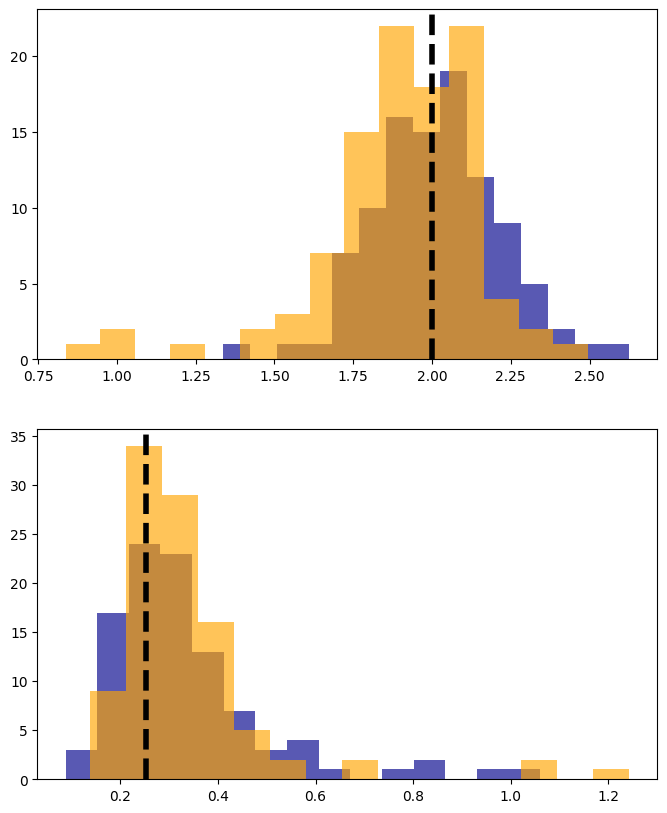

In [93]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(two_node_benchmark['10']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(two_node_benchmark['10']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(tf_comparison_result.loc[1, "Ground_truth"] - tf_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(two_node_benchmark['10']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(two_node_benchmark['10']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(tf_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

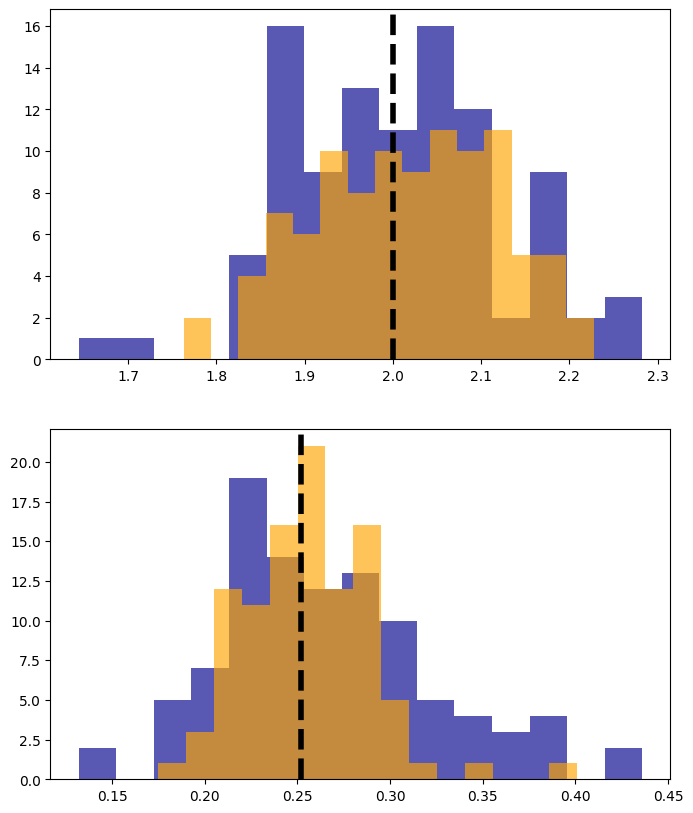

In [95]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(two_node_benchmark['30']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(two_node_benchmark['30']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(tf_comparison_result.loc[1, "Ground_truth"] - tf_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(two_node_benchmark['30']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(two_node_benchmark['30']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(tf_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

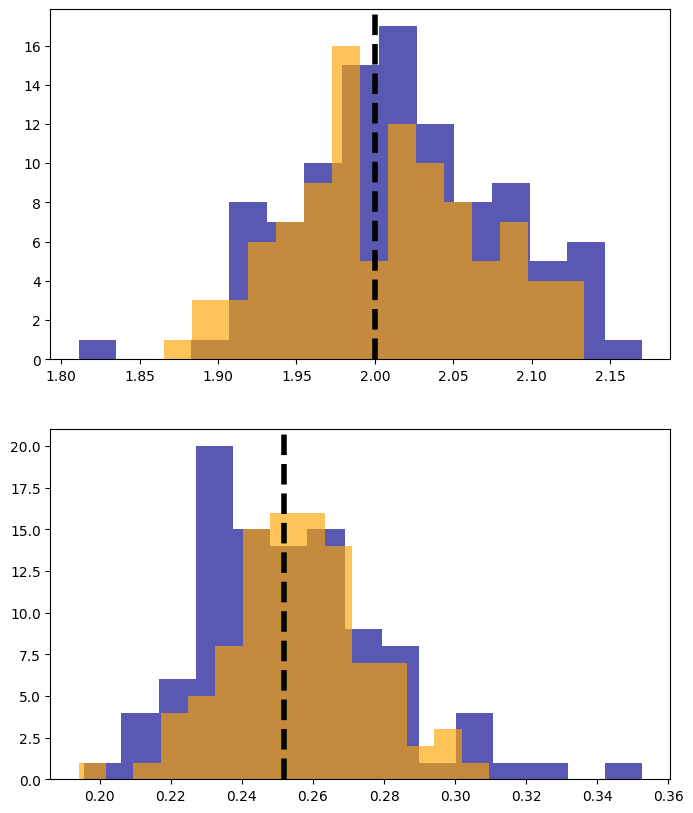

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(two_node_benchmark['100']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(two_node_benchmark['100']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(tf_comparison_result.loc[1, "Ground_truth"] - tf_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(two_node_benchmark['100']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(two_node_benchmark['100']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(tf_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

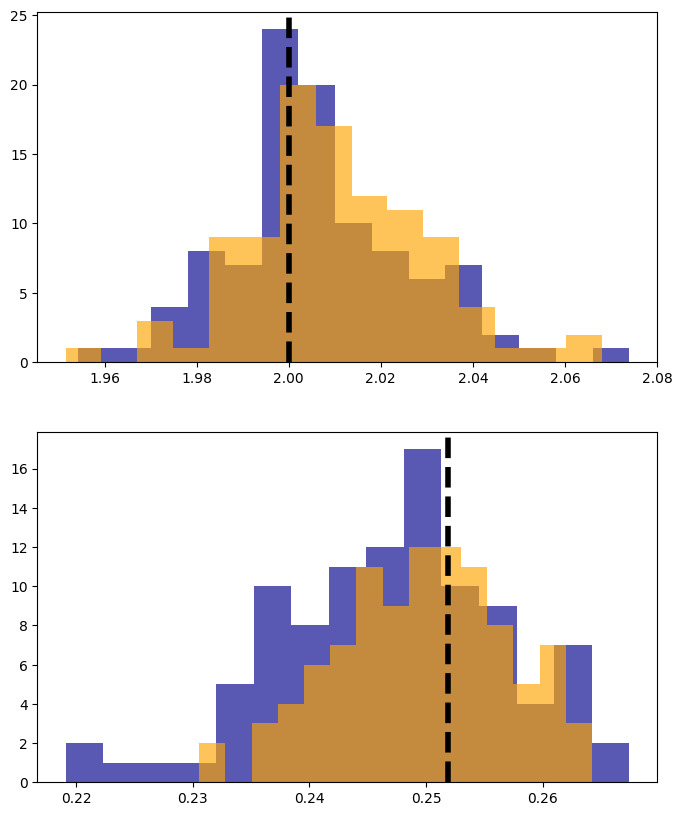

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(two_node_benchmark['1000']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(two_node_benchmark['1000']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(tf_comparison_result.loc[1, "Ground_truth"] - tf_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(two_node_benchmark['1000']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(two_node_benchmark['1000']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(tf_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

## Mediator

In [103]:
with open("../../data/methods_paper_data/tf_sim/three_node_result.pickle", "rb") as f:
    three_node_benchmark = pickle.load(f)

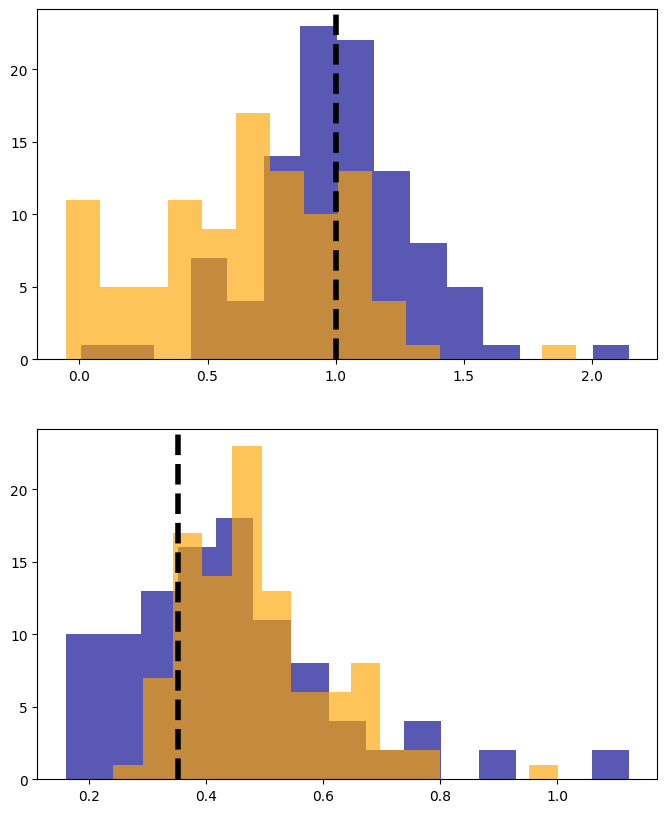

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(three_node_benchmark['10']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(three_node_benchmark['10']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(med_comparison_result.loc[1, "Ground_truth"] - med_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(three_node_benchmark['10']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(three_node_benchmark['10']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(med_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

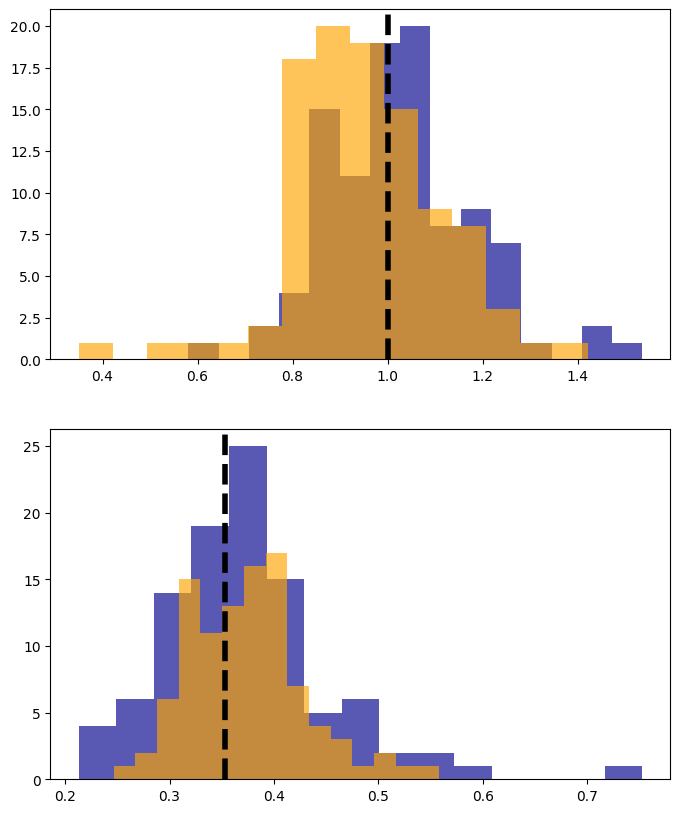

In [106]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(three_node_benchmark['30']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(three_node_benchmark['30']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(med_comparison_result.loc[1, "Ground_truth"] - med_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(three_node_benchmark['30']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(three_node_benchmark['30']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(med_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

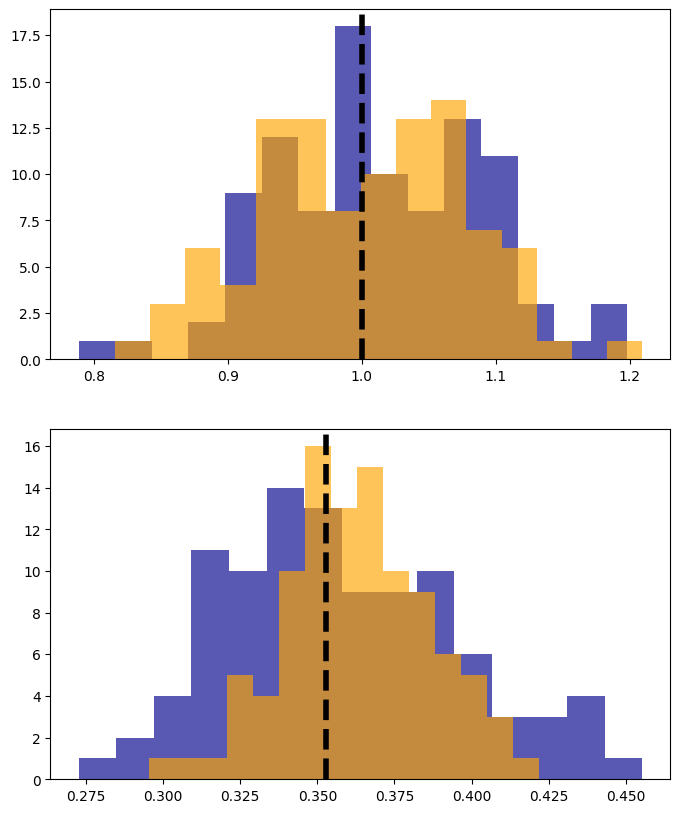

In [107]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(three_node_benchmark['100']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(three_node_benchmark['100']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(med_comparison_result.loc[1, "Ground_truth"] - med_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(three_node_benchmark['100']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(three_node_benchmark['100']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(med_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

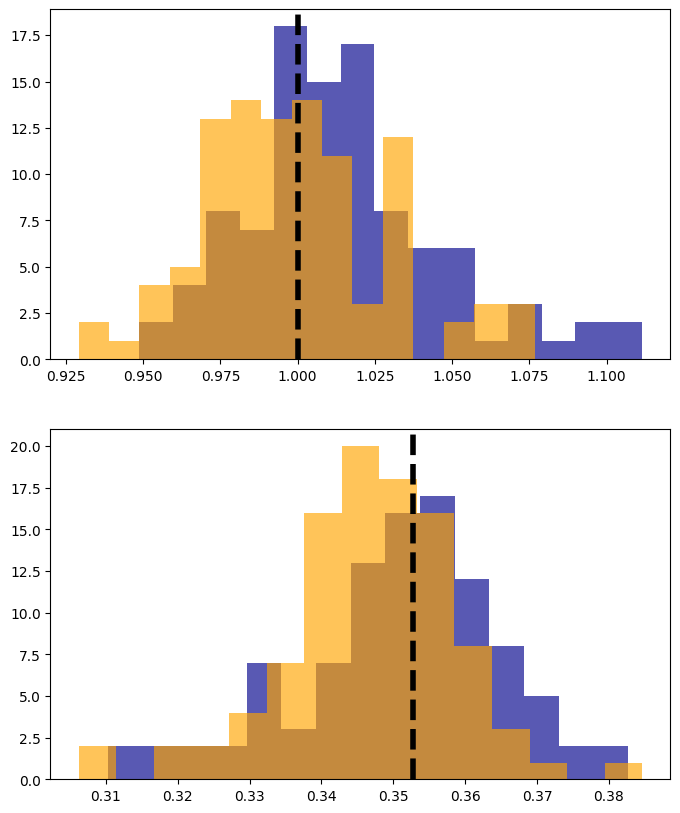

In [108]:
fig, ax = plt.subplots(2, 1, figsize=(8,10))

ax[0].hist(three_node_benchmark['1000']["eliate_ate"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[0].hist(three_node_benchmark['1000']["mscausality_ate"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[0].axvline(med_comparison_result.loc[1, "Ground_truth"] - med_comparison_result.loc[0, "Ground_truth"], 
                  color="black", linestyle="dashed", lw=4)

ax[1].hist(three_node_benchmark['1000']["eliate_var"], alpha=.65, bins=15, 
           color="darkblue", label="Eliater")
ax[1].hist(three_node_benchmark['1000']["mscausality_var"], alpha=.65, bins=15, 
           color="orange", label="MScausality")
ax[1].axvline(med_comparison_result.loc[1, "Ground_truth_std"], 
                  color="black", linestyle="dashed", lw=4)

# IGF

## Setup data and graph

In [3]:
def build_igf_network():
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    return graph

def build_admg(graph, cell_confounder=False, cell_latent=False):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
    
    ## Add in cell_type if included
    if cell_confounder:
        all_nodes.append("cell_type")
        if cell_latent:
            latent_nodes.append("cell_type")
        else:
            obs_nodes.append("cell_type")
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    # simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("SOS", "Ras")
alt_graph.add_undirected_edge("SOS", "PI3K")
alt_graph.add_directed_edge("Ras", "PI3K")
alt_graph.add_directed_edge("Ras", "Raf")
alt_graph.add_directed_edge("PI3K", "Akt")
alt_graph.add_directed_edge("Akt", "Raf")
alt_graph.add_directed_edge("Raf", "Mek")
alt_graph.add_directed_edge("Mek", "Erk")

int_graph = y0.graph.NxMixedGraph()
int_graph.add_directed_edge("SOS", "Ras")
int_graph.add_directed_edge("Ras", "Erk")
int_graph.add_undirected_edge("SOS", "Erk")

In [4]:
bulk_graph = build_igf_network()
y0_graph_bulk = build_admg(bulk_graph)

In [5]:
# ## Coefficients for relations
# cell_coef = {'EGF': {'intercept': 10., "error": 1},
#               'IGF': {'intercept': 8., "error": 1},
#               'SOS': {'intercept': -4, "error": .5, 
#                       'EGF': 0.6, 'IGF': 0.6},
#               'Ras': {'intercept': 4, "error": .5, 'SOS': .5},
#               'PI3K': {'intercept': 1.6, "error": .5, 
#                        'EGF': .5, 'IGF': 0.5, 'Ras': .5},
#               'Akt': {'intercept': 2., "error": .5, 'PI3K': 0.75},
#               'Raf': {'intercept': 1, "error": .5,
#                       'Ras': 0.8, 'Akt': -.4},
#               'Mek': {'intercept': 3., "error": .5, 'Raf': 0.75},
#               'Erk': {'intercept': -4., "error": .5, 'Mek': 1.2}
#              }

cell_coef = {'EGF': {'intercept': 10., "error": 1},
              'IGF': {'intercept': 8., "error": 1},
              'SOS': {'intercept': -2, "error": .5, 
                      'EGF': 0.6, 'IGF': 0.6},
              'Ras': {'intercept': 3, "error": .5, 'SOS': .5},
              'PI3K': {'intercept': 1.6, "error": .5, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5},
              'Akt': {'intercept': 3., "error": .5, 'PI3K': 0.75},
              'Raf': {'intercept': 8, "error": .5,
                      'Ras': 0.8, 'Akt': -.4},
              'Mek': {'intercept': 3., "error": .5, 'Raf': 0.75},
              'Erk': {'intercept': 0., "error": .5, 'Mek': 1.2}
             }

simulating data...


[-2.0,
 20.0,
 -2.0,
 20.0,
 -2.0,
 20.0,
 -2.0,
 20.0,
 -2.0,
 20.0,
 -2.0,
 20.0,
 -2.0,
 20.0,
 -2.0,
 20.0]

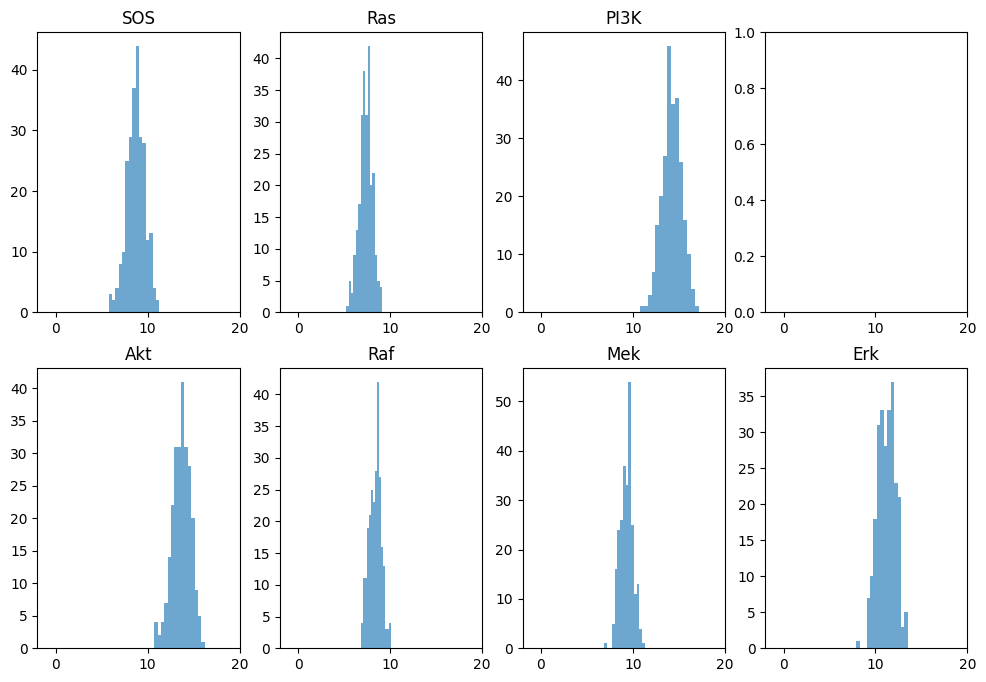

In [6]:
igf_data = simulate_data(bulk_graph, coefficients=cell_coef, mnar_missing_param=[-4, .3],
                        add_feature_var=False, n=250, seed=2)
                        
fig, ax = plt.subplots(2, 4, figsize=(12, 8))

ax[0, 0].hist(igf_data["Protein_data"]["SOS"], alpha=.65, bins=15)
ax[0, 1].hist(igf_data["Protein_data"]["Ras"], alpha=.65, bins=15)
ax[0, 2].hist(igf_data["Protein_data"]["PI3K"], alpha=.65, bins=15)

ax[1, 0].hist(igf_data["Protein_data"]["Akt"], alpha=.65, bins=15)
ax[1, 1].hist(igf_data["Protein_data"]["Raf"], alpha=.65, bins=15)
ax[1, 2].hist(igf_data["Protein_data"]["Mek"], alpha=.65, bins=15)
ax[1, 3].hist(igf_data["Protein_data"]["Erk"], alpha=.65, bins=15)

ax[0, 0].set_title("SOS")
ax[0, 1].set_title("Ras")
ax[0, 2].set_title("PI3K")
ax[1, 0].set_title("Akt")
ax[1, 1].set_title("Raf")
ax[1, 2].set_title("Mek")
ax[1, 3].set_title("Erk")

plt.setp(ax, xlim=(-2,20))

              

## Generate data and confirm it looks correct

In [51]:
igf_data = simulate_data(bulk_graph, coefficients=cell_coef, mnar_missing_param=[-4, .3],
                        add_feature_var=True, n=1000, seed=11)
                        
igf_data = dataProcess(igf_data["Feature_data"], 
                       MBimpute=False,
                       normalization=False, 
                       sim_data=True)


simulating data...
adding feature level data...
masking data...


In [8]:
igf_data

,EGF,IGF,SOS,Ras,PI3K,Akt,Raf,Mek,Erk
0,10.847510,9.612692,NaN,7.756142,14.861078,14.825839,8.963922,9.878782,11.512331
1,NaN,8.640269,NaN,7.598879,14.863816,14.672262,8.756991,9.452575,11.279241
2,6.868296,7.960972,8.322947,8.261588,13.713138,13.073846,8.991659,9.923178,11.553432
3,8.501834,8.203676,8.163827,6.173414,13.371319,12.892429,NaN,8.846777,10.283506
4,9.934815,NaN,10.153299,7.525658,13.763941,14.068563,8.731868,9.632738,11.653187
...,...,...,...,...,...,...,...,...,...
995,10.640299,8.484173,10.433884,8.598028,15.131308,14.036536,9.326008,9.864556,11.496377
996,NaN,8.676378,10.183588,6.947000,14.744588,14.637009,8.371675,10.620438,12.982155
997,10.066770,9.956187,11.238027,8.635200,16.451558,15.965641,8.738572,9.662750,11.913916
998,7.536118,6.391290,6.950604,6.732007,11.764927,12.378747,9.877611,10.480077,12.524983


In [9]:
igf_data.isna().sum(axis=1) / len(igf_data.columns)

0      0.111111
1      0.222222
2      0.000000
3      0.111111
4      0.111111
         ...   
995    0.000000
996    0.111111
997    0.000000
998    0.000000
999    0.111111
Length: 1000, dtype: float64

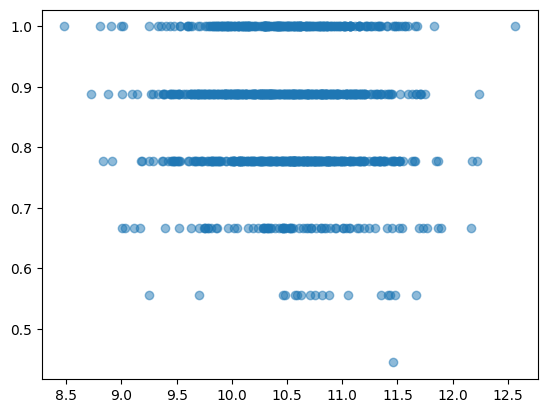

In [10]:
fig, ax = plt.subplots()
ax.scatter(x=igf_data.mean(axis=1), y= 1-igf_data.isna().sum(axis=1) / len(igf_data.columns), alpha=.5)


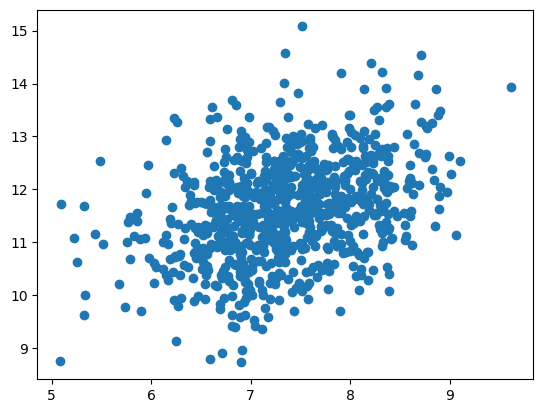

In [11]:
fig, ax = plt.subplots()
ax.scatter(igf_data.loc[:, "Ras"], igf_data.loc[:, "Erk"])

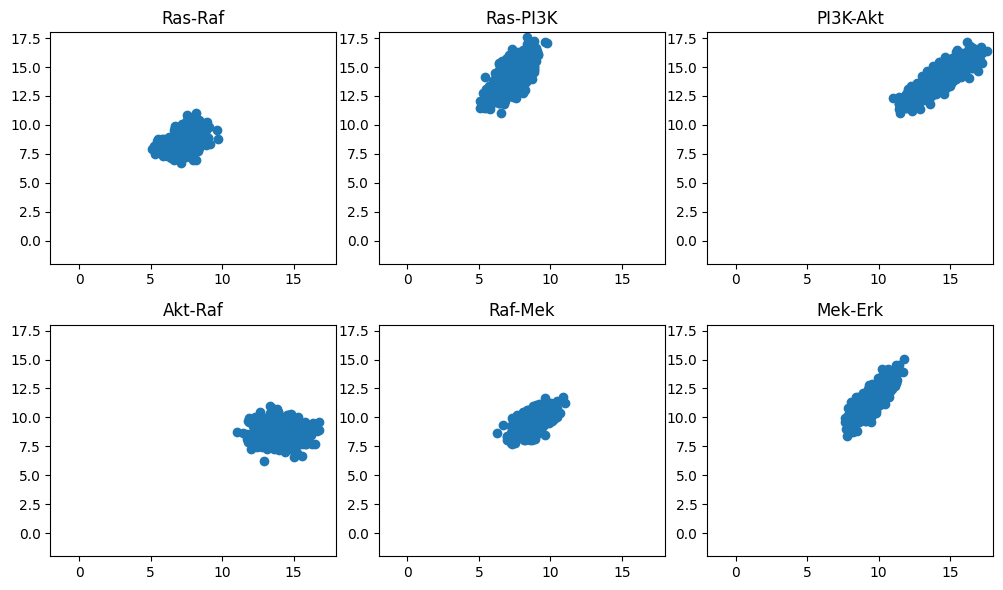

In [12]:
fig, ax = plt.subplots(2,3, figsize=(10,6))
ax[0,0].scatter(igf_data.loc[:, "Ras"], igf_data.loc[:, "Raf"])
ax[0,1].scatter(igf_data.loc[:, "Ras"], igf_data.loc[:, "PI3K"])
ax[0,2].scatter(igf_data.loc[:, "PI3K"], igf_data.loc[:, "Akt"])
ax[1,0].scatter(igf_data.loc[:, "Akt"], igf_data.loc[:, "Raf"])
ax[1,1].scatter(igf_data.loc[:, "Raf"], igf_data.loc[:, "Mek"])
ax[1,2].scatter(igf_data.loc[:, "Mek"], igf_data.loc[:, "Erk"])

ax[0,0].set_xlim(-2,18)
ax[0,1].set_xlim(-2,18)
ax[0,2].set_xlim(-2,18)
ax[0,0].set_ylim(-2,18)
ax[0,1].set_ylim(-2,18)
ax[0,2].set_ylim(-2,18)
ax[1,0].set_xlim(-2,18)
ax[1,1].set_xlim(-2,18)
ax[1,2].set_xlim(-2,18)
ax[1,0].set_ylim(-2,18)
ax[1,1].set_ylim(-2,18)
ax[1,2].set_ylim(-2,18)

ax[0,0].set_title("Ras-Raf")
ax[0,1].set_title("Ras-PI3K")
ax[0,2].set_title("PI3K-Akt")
ax[1,0].set_title("Akt-Raf")
ax[1,1].set_title("Raf-Mek")
ax[1,2].set_title("Mek-Erk")

fig.tight_layout()

## Benchmarks

In [15]:
int1 = {"Ras": 5}
int2 = {"Ras": 7}
outcome = "Erk"

# Ground truth
intervention_low = simulate_data(bulk_graph, coefficients=cell_coef,
                                 intervention=int1, 
                                    add_feature_var=False, n=10000, seed=2)

intervention_high = simulate_data(bulk_graph, coefficients=cell_coef,
                                  intervention=int2, 
                                  add_feature_var=False, n=10000, seed=2)

# Eliator prediction
imputer = KNNImputer(n_neighbors=5)
obs_data_eliator = igf_data.loc[:, [
    i for i in igf_data.columns if i not in ["IGF", "EGF"]]].copy()
obs_data_eliator = pd.DataFrame(imputer.fit_transform(obs_data_eliator), 
                                columns=obs_data_eliator.columns)

eliator_int_low = summary_statistics(
    y0_graph_bulk, obs_data_eliator,
    treatments={Variable(list(int1.keys())[0])},
    outcome=Variable(outcome),
    interventions={
        Variable(list(int1.keys())[0]): list(int1.values())[0]})

eliator_int_high = summary_statistics(
    y0_graph_bulk, obs_data_eliator,
    treatments={Variable(list(int2.keys())[0])},
    outcome=Variable(outcome),
    interventions={
        Variable(list(int2.keys())[0]): list(int2.values())[0]})

simulating data...
simulating data...


In [16]:
gt_ate = (intervention_high["Protein_data"][outcome].mean() \
          - intervention_low["Protein_data"][outcome].mean() )
eliator_ate = eliator_int_high.mean - eliator_int_low.mean
eliator_ate

1.2477998616350234

## Basic model

In [28]:
pyro.clear_param_store()
transformed_data = normalize(igf_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

lvm = LVM(input_data, int_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.get_priors()

lvm.fit_model(num_steps=10000, patience=50)

Step 0: Loss = 2222.1140815410763
Step 100: Loss = -775.9778342247009
Step 200: Loss = -1442.5215781927109
Step 300: Loss = -1743.2160956859589
Step 400: Loss = -1946.9647929668427
Step 500: Loss = -2064.2171918451786
Step 600: Loss = -2161.6261959671974
Step 700: Loss = -2240.7219955325127
Step 800: Loss = -2286.198112666607
Stopping early at step 809 with loss -2282.874135404825


In [29]:
lvm.parameters

,parameter,mean,scale
0,SOS_int,-0.824345,0.021546438
1,SOS_scale,-1.0429229,0.04090039
2,Ras_int,-0.70923,0.014470628
3,Ras_SOS_coef,0.36504048,0.015787322
4,Ras_scale,-1.536734,0.047275584
5,Erk_int,0.7705327,0.017072506
6,Erk_Ras_coef,0.41331694,0.019078355
7,Erk_scale,-1.059481,0.05130021


In [30]:
lvm.priors

{'latent_0': {'latent_0_int': 0, 'latent_0_scale': 1},
 'SOS': {'SOS_int': 0, 'SOS_latent_0_coef': 0.5},
 'Ras': {'Ras_SOS_coef': 0.39041114, 'Ras_int': -0.7105653},
 'Erk': {'Erk_Ras_coef': 0.45572397,
  'Erk_latent_0_coef': 0.5,
  'Erk_int': 0.92932844}}

In [31]:
## MScausality results
lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_low = lvm.intervention_samples
lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_high = lvm.intervention_samples

mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                       + scale_metrics["mean"])
mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                        + scale_metrics["mean"])
mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()

In [49]:
mscausality_int_high.mean()

tensor(11.1702)

In [50]:
mscausality_int_low.mean()

tensor(10.3545)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        7.0000e+00, 1.6000e+01, 4.2000e+01, 1.2800e+02, 3.3000e+02,
        8.4300e+02, 1.8640e+03, 3.7400e+03, 6.3590e+03, 9.8200e+03,
        1.3396e+04, 1.6461e+04, 1.7363e+04, 1.6541e+04, 1.3772e+04,
        1.0081e+04, 6.7400e+03, 3.8900e+03, 2.0450e+03, 9.2500e+02,
        4.2200e+02, 1.3400e+02, 5.3000e+01, 1.6000e+01, 8.0000e+00]),
 array([ 5.42976093,  5.75682878,  6.08389616,  6.41096401,  6.73803139,
         7.06509924,  7.39216709,  7.71923447,  8.04630184,  8.37337017,
         8.70043755,  9.02750492,  9.35457325,  9.68164062, 10.008708  ,
        10.33577538, 10.6628437 , 10.98991108, 11.31697845, 11.64404678,
        11.97111416, 12.29818153, 12.62524986, 12.95231724, 13.27938461,
        13.60645294, 13.93352032, 14.26058769, 14.58765507, 14.9147234 ,
        15.24179077]),
 <BarContainer object of 30 artists>)

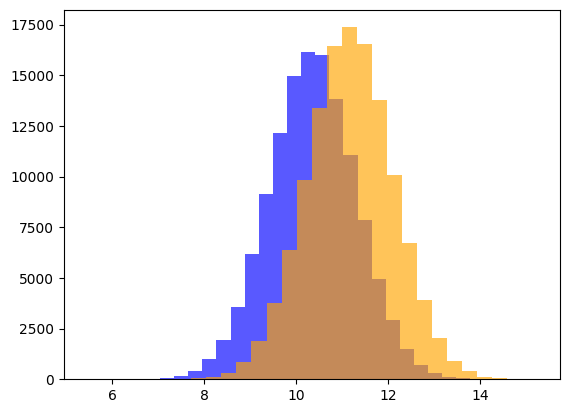

In [45]:
fig, ax = plt.subplots()
ax.hist(mscausality_int_low, color="blue", alpha=.65, bins=30)
ax.hist(mscausality_int_high, color="orange", alpha=.65, bins=30)

In [32]:
print(f"GT: {gt_ate}")
print(f"Eliater: {eliator_ate}")
print(f"Basic Model: {mscausality_ate}")

GT: 1.17
Eliater: 1.2477998616350234
Basic Model: 0.8157749176025391


Text(0.5, 1.0, '')

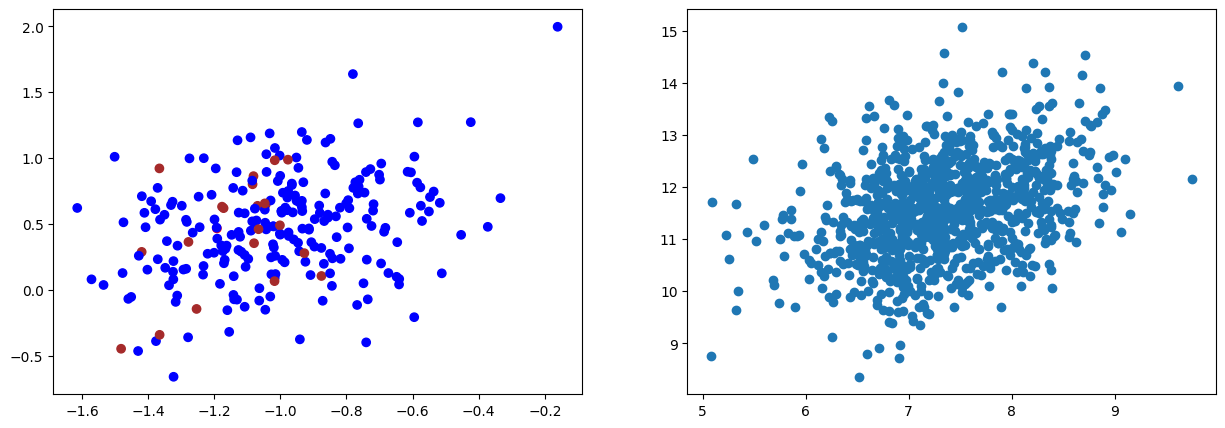

In [33]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((ras_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", np.where((ras_data['intensity'].isna().values & erk_data['imp_mean'].isna().values), 
                                     "brown", "orange")))

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(ras_data, erk_data, color=ras_raf_backdoor_color)
ax[1].scatter(obs_data_eliator["Ras"],
              obs_data_eliator["Erk"])

ax[0].set_title("")

Text(0.5, 0, 'SOS')

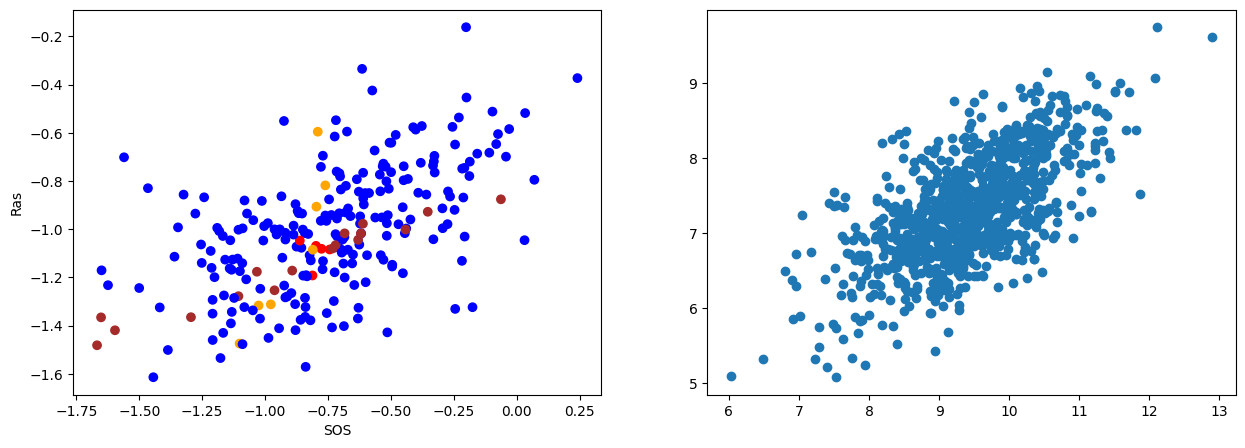

In [34]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
erk_data = imp_data.loc[imp_data["protein"] == "SOS"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((ras_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", np.where((ras_data['intensity'].isna().values & erk_data['imp_mean'].isna().values), 
                                     "brown", "orange")))

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(erk_data, ras_data, color=ras_raf_backdoor_color)
ax[1].scatter(obs_data_eliator["SOS"], obs_data_eliator["Ras"])
ax[0].set_ylabel("Ras")
ax[0].set_xlabel("SOS")

In [35]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]
sos_data = imp_data.loc[imp_data["protein"] == "SOS"]

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])
sos_data = np.where(sos_data['imp_mean'].isna(), sos_data['intensity'], sos_data['imp_mean'])

test = pd.concat([pd.Series(ras_data), 
                  pd.Series(erk_data), 
                  pd.Series(sos_data)], axis=1)
test.columns = ["Ras", "Erk", "SOS"]

In [42]:
lm = LinearRegression()
lm.fit(obs_data_eliator["SOS"].values.reshape(-1,1), obs_data_eliator["Ras"])
print(lm.coef_)

lm = LinearRegression()
lm.fit(test["SOS"].values.reshape(-1,1), test["Ras"])
print(lm.coef_)

[0.51843059]
[0.40374484]


In [41]:
lm = LinearRegression()
lm.fit(obs_data_eliator["Ras"].values.reshape(-1,1), obs_data_eliator["Erk"])
print(lm.coef_)

lm = LinearRegression()
lm.fit(test["Ras"].values.reshape(-1,1), test["Erk"])
print(lm.coef_)

[0.49463409]
[0.46991507]


In [36]:
lm = LinearRegression()
lm.fit(obs_data_eliator[["SOS", "Ras"]], obs_data_eliator["Erk"])
lm.coef_

array([-0.15642046,  0.62389993])

In [40]:
lm = LinearRegression()
lm.fit(test[["SOS", "Ras"]], test["Erk"])
lm.coef_

array([-0.09590142,  0.54641313])

## Informative Priors

In [23]:
pyro.clear_param_store()
transformed_data = normalize(igf_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

lvm = LVM(input_data, int_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.get_priors()

lvm.priors['Erk']['Erk_Ras_coef'] = 1.

lvm.fit_model(num_steps=10000)

Step 0: Loss = 1782.467863894999
Step 100: Loss = -618.8590759932995
Step 200: Loss = -1140.1849195957184
Step 300: Loss = -1376.1423217952251
Step 400: Loss = -1476.45864418149
Step 500: Loss = -1637.4052326977253
Step 600: Loss = -1699.1902669668198
Step 700: Loss = -1766.145245462656
Step 800: Loss = -1833.364595323801
Step 900: Loss = -1886.6166379153728
Step 1000: Loss = -1915.4984038770199
Step 1100: Loss = -1967.777580499649
Step 1200: Loss = -1986.624954342842
Step 1300: Loss = -2031.4923974871635
Step 1400: Loss = -2047.9349268972874
Stopping early at step 1449 with loss -2081.678971886635


In [24]:
## MScausality results
lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_low = lvm.intervention_samples
lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_high = lvm.intervention_samples

mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                       + scale_metrics["mean"])
mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                        + scale_metrics["mean"])
mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()

In [26]:
print(f"GT: {gt_ate}")
print(f"Eliater: {eliator_ate}")
print(f"Inf prior Model: {mscausality_ate}")

GT: 1.17
Eliater: 1.0815560189575901
Inf prior Model: 1.2731657028198242


## Full imputation model

In [24]:
transformed_data = normalize(igf_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

lvm = LVM(input_data, alt_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.get_priors()

pyro.clear_param_store()

lvm.fit_model(num_steps=10000)

Step 0: Loss = 4593.598328507505
Step 100: Loss = -1427.820728957653
Step 200: Loss = -2959.613348454237
Step 300: Loss = -3621.145116955042
Step 400: Loss = -3947.261956691742
Step 500: Loss = -4264.1208400428295
Step 600: Loss = -4463.656793832779
Step 700: Loss = -4665.249491155148
Step 800: Loss = -4800.298148840666
Step 900: Loss = -4965.126983195543
Step 1000: Loss = -4987.360663473606
Step 1100: Loss = -5119.441469699144
Step 1200: Loss = -5242.777459383011
Step 1300: Loss = -5303.119030326605
Step 1400: Loss = -5339.234459519386
Step 1500: Loss = -5411.369823932648
Step 1600: Loss = -5398.434535592794
Step 1700: Loss = -5501.6824224591255
Step 1800: Loss = -5636.449721097946
Stopping early at step 1805 with loss -5562.21393340826


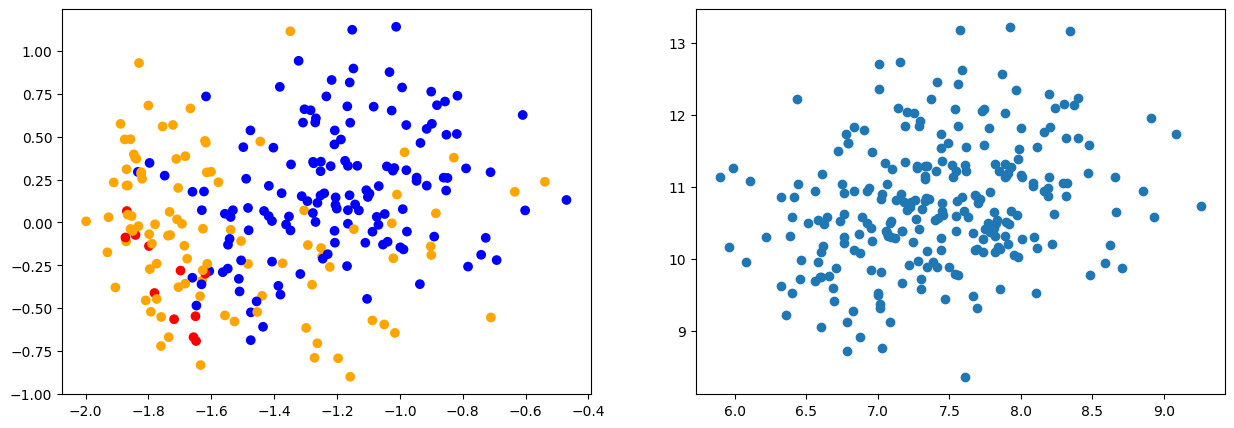

In [28]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((ras_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", "orange"))

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(ras_data, erk_data, color=ras_raf_backdoor_color)
ax[1].scatter(obs_data_eliator["Ras"],
              obs_data_eliator["Erk"])

In [25]:
## MScausality results
lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_low = lvm.intervention_samples
lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_high = lvm.intervention_samples

mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                       + scale_metrics["mean"])
mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                        + scale_metrics["mean"])
mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()

In [26]:
lvm.parameters

,parameter,mean,scale
0,Ras_int,-1.160254,0.024577662
1,Ras_SOS_coef,0.27409455,0.025949605
2,Ras_scale,-0.9084003,0.038414996
3,PI3K_int,2.4422154,0.027322378
4,PI3K_Ras_coef,0.58976674,0.0184199
5,PI3K_scale,-0.8903682,0.046442393
6,Akt_int,0.08887835,0.0120972665
7,Akt_PI3K_coef,0.7337629,0.007413599
8,Akt_scale,-1.6167319,0.045360547
9,Raf_int,0.0526589,0.021702979


In [29]:
print(f"GT: {gt_ate}")
print(f"Eliater: {eliator_ate}")
print(f"Full Model: {mscausality_ate}")

GT: 1.17
Eliater: 1.0220284760977396
Full Model: 0.14206790924072266


## Full imputation and informative priors

In [52]:
transformed_data = normalize(igf_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]

lvm = LVM(input_data, alt_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.get_priors()

for i in lvm.priors.keys():
    for v in lvm.priors[i].keys():
        if (v != "Raf_Akt_coef") & ("coef" in v): 
            if (lvm.priors[i][v]) < 1:
                lvm.priors[i][v] = 1

pyro.clear_param_store()

lvm.fit_model(num_steps=10000)


Step 0: Loss = 19431.391730584204
Step 100: Loss = -8335.932303249836
Step 200: Loss = -15187.287086367607
Step 300: Loss = -17854.511375516653
Step 400: Loss = -19667.568293333054
Step 500: Loss = -20940.773994594812
Step 600: Loss = -21756.298823863268
Step 700: Loss = -22545.637500554323
Step 800: Loss = -23254.428637325764
Step 900: Loss = -23806.777237445116
Step 1000: Loss = -24247.450515061617
Step 1100: Loss = -24752.01270765066
Step 1200: Loss = -25281.217440754175
Step 1300: Loss = -25487.13928502798
Step 1400: Loss = -25853.96745607257
Step 1500: Loss = -26040.634120225906
Step 1600: Loss = -26365.946457505226
Step 1700: Loss = -26567.95377674699
Step 1800: Loss = -26873.140974342823
Step 1900: Loss = -27054.114748448133
Step 2000: Loss = -27334.173112392426
Step 2100: Loss = -27543.451005011797
Step 2200: Loss = -27681.865398466587
Step 2300: Loss = -27937.6441283226
Step 2400: Loss = -28046.58327704668
Step 2500: Loss = -28270.931116461754
Step 2600: Loss = -28403.14368724

In [53]:
## MScausality results
lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_low = lvm.intervention_samples
lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                         - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
mscausality_int_high = lvm.intervention_samples

mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                       + scale_metrics["mean"])
mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                        + scale_metrics["mean"])
mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()

In [54]:
print(f"GT: {gt_ate}")
print(f"Eliater: {eliator_ate}")
print(f"Full Model with inf priors: {mscausality_ate}")

GT: 1.17
Eliater: 1.2477998616350234
Full Model with inf priors: 0.9445257186889648


In [24]:
lvm.priors

{'latent_0': {'latent_0_int': 0, 'latent_0_scale': 1},
 'SOS': {'SOS_int': 0, 'SOS_latent_0_coef': 1},
 'Ras': {'Ras_SOS_coef': 1, 'Ras_int': -0.7105653},
 'PI3K': {'PI3K_Ras_coef': 1, 'PI3K_latent_0_coef': 1, 'PI3K_int': 2.6488576},
 'Akt': {'Akt_PI3K_coef': 1, 'Akt_int': 0.01029551},
 'Raf': {'Raf_Ras_coef': 1, 'Raf_Akt_coef': -0.3471342, 'Raf_int': 0.40000796},
 'Mek': {'Mek_Raf_coef': 1, 'Mek_int': 0.15128869},
 'Erk': {'Erk_Mek_coef': 1.1265962, 'Erk_int': 0.8820487}}

In [25]:
lvm.parameters

,parameter,mean,scale
0,SOS_int,-1.0094637,0.014249519
1,SOS_scale,-1.3986093,0.042167712
2,Ras_int,-0.6451157,0.012203295
3,Ras_SOS_coef,0.48109603,0.01416508
4,Ras_scale,-1.5424769,0.04036682
5,PI3K_int,2.1741643,0.012084883
6,PI3K_Ras_coef,0.7121817,0.011372217
7,PI3K_scale,-1.6448493,0.039495803
8,Akt_int,-0.044844806,0.013887827
9,Akt_PI3K_coef,0.76471883,0.0073738787


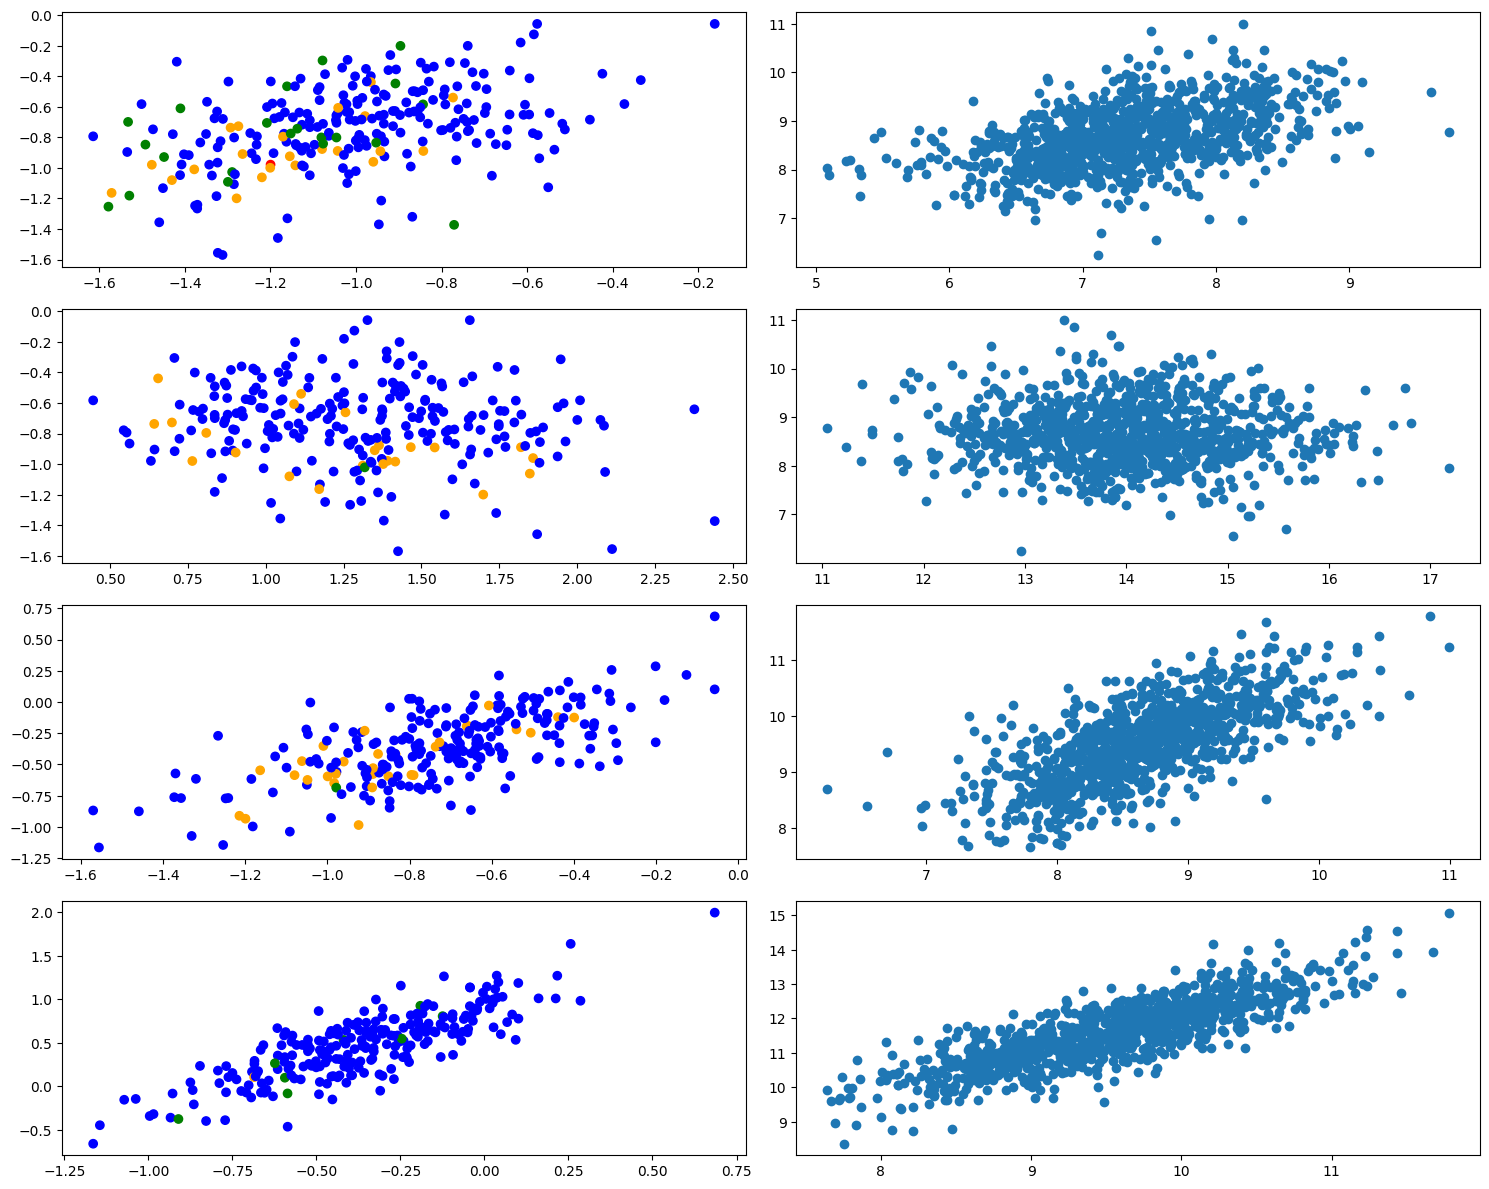

In [26]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
akt_data = imp_data.loc[imp_data["protein"] == "Akt"]
raf_data = imp_data.loc[imp_data["protein"] == "Raf"]
mek_data = imp_data.loc[imp_data["protein"] == "Mek"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & raf_data['imp_mean'].isna().values), "blue", 
    np.where((ras_data['intensity'].isna().values & raf_data['intensity'].isna().values), "red", 
             np.where((ras_data['intensity'].isna().values & raf_data['imp_mean'].isna().values), "green", 
                      "orange")))

akt_raf_backdoor_color = np.where(
    (akt_data['imp_mean'].isna().values & raf_data['imp_mean'].isna().values), "blue", 
    np.where((akt_data['intensity'].isna().values & raf_data['intensity'].isna().values), "red", 
             np.where((akt_data['intensity'].isna().values & raf_data['imp_mean'].isna().values), "green", 
                      "orange")))

raf_mek_backdoor_color = np.where(
    (raf_data['imp_mean'].isna().values & mek_data['imp_mean'].isna().values), "blue", 
    np.where((raf_data['intensity'].isna().values & mek_data['intensity'].isna().values), "red", 
             np.where((ras_data['intensity'].isna().values & mek_data['imp_mean'].isna().values), "green", 
                      "orange")))

mek_erk_backdoor_color = np.where(
    (mek_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), "blue", 
    np.where((mek_data['intensity'].isna().values & erk_data['intensity'].isna().values), "red", 
             np.where((mek_data['intensity'].isna().values & erk_data['imp_mean'].isna().values), "green", 
                      "orange")))


ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
akt_data = np.where(akt_data['imp_mean'].isna(), akt_data['intensity'], akt_data['imp_mean'])
raf_data = np.where(raf_data['imp_mean'].isna(), raf_data['intensity'], raf_data['imp_mean'])
mek_data = np.where(mek_data['imp_mean'].isna(), mek_data['intensity'], mek_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

fig, ax = plt.subplots(4,2,figsize=(15,12))
ax[0,0].scatter(ras_data, raf_data, color=ras_raf_backdoor_color)
ax[0,1].scatter(obs_data_eliator["Ras"],
              obs_data_eliator["Raf"])

ax[1,0].scatter(akt_data, raf_data, color=akt_raf_backdoor_color)
ax[1,1].scatter(obs_data_eliator["Akt"],
              obs_data_eliator["Raf"])

ax[2,0].scatter(raf_data, mek_data, color=raf_mek_backdoor_color)
ax[2,1].scatter(obs_data_eliator["Raf"],
              obs_data_eliator["Mek"])

ax[3,0].scatter(mek_data, erk_data, color=mek_erk_backdoor_color)
ax[3,1].scatter(obs_data_eliator["Mek"],
              obs_data_eliator["Erk"])

plt.tight_layout()

In [55]:
imp_data = lvm.imputed_data

sos_data = imp_data.loc[imp_data["protein"] == "SOS"]
ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
akt_data = imp_data.loc[imp_data["protein"] == "Akt"]
raf_data = imp_data.loc[imp_data["protein"] == "Raf"]
mek_data = imp_data.loc[imp_data["protein"] == "Mek"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

sos_data = np.where(sos_data['imp_mean'].isna(), sos_data['intensity'], sos_data['imp_mean'])
ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
akt_data = np.where(akt_data['imp_mean'].isna(), akt_data['intensity'], akt_data['imp_mean'])
raf_data = np.where(raf_data['imp_mean'].isna(), raf_data['intensity'], raf_data['imp_mean'])
mek_data = np.where(mek_data['imp_mean'].isna(), mek_data['intensity'], mek_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

test = pd.concat([pd.Series(sos_data),
                  pd.Series(ras_data),
                  pd.Series(akt_data),
                  pd.Series(raf_data),
                  pd.Series(mek_data), 
                  pd.Series(erk_data)], axis=1)
test.columns = ["SOS", "Ras", "Akt", "Raf", "Mek", "Erk"]

In [56]:
lm = LinearRegression()
lm.fit(obs_data_eliator[["SOS", "Ras"]], obs_data_eliator["Erk"])
lm.coef_

array([-0.15642046,  0.62389993])

In [57]:
lm = LinearRegression()
lm.fit(test[["SOS", "Ras"]], test["Erk"])
lm.coef_

array([-0.15644015,  0.504623  ])

In [58]:
lm = LinearRegression()
lm.fit(obs_data_eliator[["Akt", "Ras"]], obs_data_eliator["Raf"])
print(lm.coef_)

lm = LinearRegression()
lm.fit(test[["Akt", "Ras"]], test["Raf"])
print(lm.coef_)

[-0.33376724  0.70066192]
[-0.36100518  0.75409243]


In [59]:
lm = LinearRegression()
lm.fit(obs_data_eliator[["Raf"]].values.reshape(-1,1), obs_data_eliator["Mek"])
print(lm.coef_)

lm = LinearRegression()
lm.fit(test[["Raf"]].values.reshape(-1,1), test["Mek"])
print(lm.coef_)

[0.78106946]
[0.70054286]


In [60]:
lm = LinearRegression()
lm.fit(obs_data_eliator[["Mek"]].values.reshape(-1,1), obs_data_eliator["Erk"])
print(lm.coef_)

lm = LinearRegression()
lm.fit(test[["Mek"]].values.reshape(-1,1), test["Erk"])
print(lm.coef_)

[1.07663111]
[1.12005243]


## Loop sim

In [161]:
int1 = {"Ras": 5}
int2 = {"Ras": 7}
outcome = "Erk"

def intervention(model, int1, int2, outcome, scale_metrics):
    ## MScausality results
    model.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                            - scale_metrics["mean"]) \
                                                / scale_metrics["std"]}, outcome)
    mscausality_int_low = model.intervention_samples
    model.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                            - scale_metrics["mean"]) \
                                                / scale_metrics["std"]}, outcome)
    mscausality_int_high = model.intervention_samples

    mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                        + scale_metrics["mean"])
    mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                            + scale_metrics["mean"])
    mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()

    return mscausality_ate


In [164]:

def comparison(bulk_graph, 
               y0_graph_bulk, 
               cell_coef, 
               int1, 
               int2, 
               outcome,
               alt_graph,
               int_graph,
               data):
    
    # Ground truth
    intervention_low = simulate_data(bulk_graph, coefficients=cell_coef,
                                    intervention=int1, mnar_missing_param=[-4, .3],
                                    add_feature_var=False, n=10000, seed=2)

    intervention_high = simulate_data(bulk_graph, coefficients=cell_coef,
                                    intervention=int2, 
                                    add_feature_var=False, n=10000, seed=2)

    gt_ate = (intervention_high["Protein_data"][outcome].mean() \
          - intervention_low["Protein_data"][outcome].mean() )
    
    # Eliator prediction
    imputer = KNNImputer(n_neighbors=5)
    obs_data_eliator = data.copy()
    obs_data_eliator = pd.DataFrame(imputer.fit_transform(obs_data_eliator), 
                                    columns=data.columns)

    eliator_int_low = summary_statistics(
        y0_graph_bulk, obs_data_eliator,
        treatments={Variable(list(int1.keys())[0])},
        outcome=Variable(outcome),
        interventions={
            Variable(list(int1.keys())[0]): list(int1.values())[0]})

    eliator_int_high = summary_statistics(
        y0_graph_bulk, obs_data_eliator,
        treatments={Variable(list(int2.keys())[0])},
        outcome=Variable(outcome),
        interventions={
            Variable(list(int2.keys())[0]): list(int2.values())[0]})
    
    eliator_ate = eliator_int_high.mean - eliator_int_low.mean

    # Basic Bayesian model
    pyro.clear_param_store()
    transformed_data = normalize(data, wide_format=True)
    input_data = transformed_data["df"]
    scale_metrics = transformed_data["adj_metrics"]

    lvm = LVM(input_data, int_graph)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.get_priors()

    lvm.fit_model(num_steps=10000)

    pyro.clear_param_store()
    lvm.fit_model(num_steps=10000)
    
    basic_model_ate = intervention(lvm, int1, int2, outcome, scale_metrics)

    # Informative prior Bayesian model
    pyro.clear_param_store()
    lvm.priors['Erk']['Erk_Ras_coef'] = 1.
    lvm.fit_model(num_steps=10000)
    
    inf_prior_model_ate = intervention(lvm, int1, int2, outcome, scale_metrics)

    # Full imp Bayesian model
    lvm = LVM(input_data, alt_graph)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.get_priors()

    pyro.clear_param_store()
    lvm.fit_model(num_steps=10000)

    full_imp_model_ate = intervention(lvm, int1, int2, outcome, scale_metrics)

    # Full imp Bayesian model with informative prior
    lvm = LVM(input_data, alt_graph)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.get_priors()

    for i in lvm.priors.keys():
        for v in lvm.priors[i].keys():
            if (v != "Raf_Akt_coef") & ("coef" in v): 
                if (lvm.priors[i][v]) < .75:
                    lvm.priors[i][v] = 1
    # lvm.priors["Mek"]["Mek_Raf_coef"] = 1.

    pyro.clear_param_store()
    lvm.fit_model(num_steps=10000)

    
    full_imp_inf_post_model_ate = intervention(lvm, int1, int2, outcome, scale_metrics)
    
    result_df = pd.DataFrame({
        "Ground_truth": [gt_ate],
        "Eliator": [eliator_ate],
        "Basic_model": [basic_model_ate.item()],
        "Inf_prior": [inf_prior_model_ate.item()],
        "Full_imp": [full_imp_model_ate.item()],
        "Full_imp_inf_post": [full_imp_inf_post_model_ate.item()]
    })

    return result_df


result = list()

for i in range(30):

    temp_data = simulate_data(bulk_graph, coefficients=cell_coef, 
                                mnar_missing_param=[-4, .3], 
                                add_feature_var=True, n=50, seed=i)

    summarized_data = dataProcess(temp_data["Feature_data"], 
                            normalization=False, 
                            feature_selection="All",
                            MBimpute=False,
                            sim_data=True)

    
    result_data = comparison(
        bulk_graph, y0_graph_bulk, cell_coef, {"Ras": 5}, {"Ras": 7}, 
        "Erk", alt_graph, int_graph, summarized_data)

    result.append(result_data)

result = pd.concat(result, ignore_index=True)

import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump(result, file)

simulating data...
adding feature level data...
masking data...
simulating data...
simulating data...
Step 0: Loss = 371.7967718541622
Step 100: Loss = -145.02653911709785
Step 200: Loss = -269.9363337755203
Step 300: Loss = -310.16240802407265
Step 400: Loss = -344.8984791338444
Step 500: Loss = -374.1087504029274
Step 600: Loss = -399.7842923402786
Step 700: Loss = -402.82833129167557
Step 800: Loss = -416.621167242527
Stopping early at step 806 with loss -431.3202714920044
Step 0: Loss = 371.7967718541622
Step 100: Loss = -145.02653911709785
Step 200: Loss = -269.9363337755203
Step 300: Loss = -310.16240802407265
Step 400: Loss = -344.8984791338444
Step 500: Loss = -374.1087504029274
Step 600: Loss = -399.7842923402786
Step 700: Loss = -402.82833129167557
Step 800: Loss = -416.621167242527
Stopping early at step 806 with loss -431.3202714920044
Step 0: Loss = 409.9184006154537
Step 100: Loss = -142.1293000280857
Step 200: Loss = -266.7425253391266
Step 300: Loss = -306.6508879065513

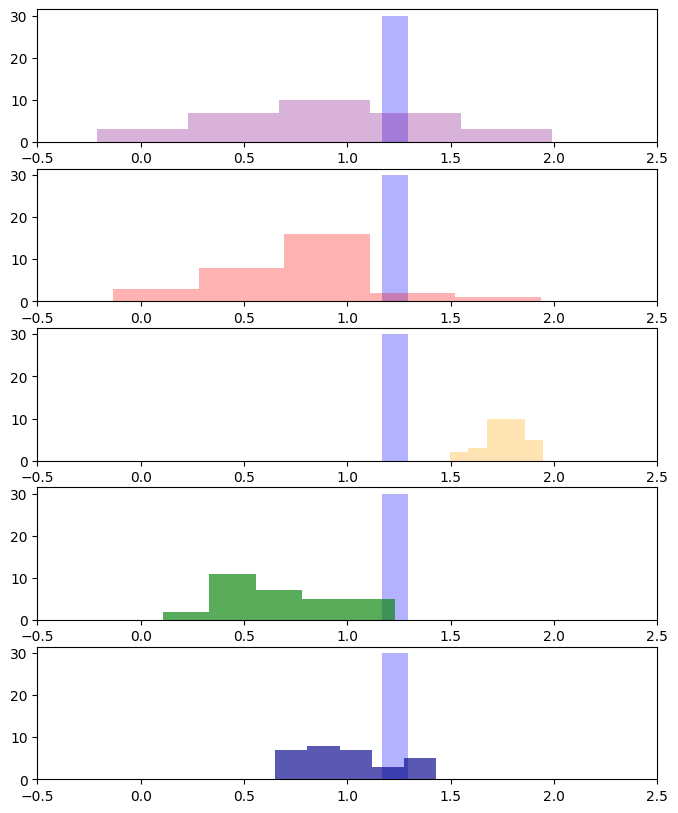

In [174]:
fig, ax = plt.subplots(5,1,figsize=(8,10))
ax[0].hist(result["Ground_truth"], alpha=.3, bins=8, color="blue")
ax[0].hist(result["Eliator"], alpha=.3, bins=5, color="purple")

ax[1].hist(result["Ground_truth"], alpha=.3, bins=8, color="blue")
ax[1].hist(result["Basic_model"], alpha=.3, bins=5, color="red")

ax[2].hist(result["Ground_truth"], alpha=.3, bins=8, color="blue")
ax[2].hist(result["Inf_prior"], alpha=.3, bins=5, color="orange")

ax[3].hist(result["Ground_truth"], alpha=.3, bins=8, color="blue")
ax[3].hist(result["Full_imp"], alpha=.65, bins=5, color="green")

ax[4].hist(result["Ground_truth"], alpha=.3, bins=8, color="blue")
ax[4].hist(result["Full_imp_inf_post"], alpha=.65, bins=5, color="darkblue")

for i in range(5):
    ax[i].set_xlim(-.5, 2.5)

In [20]:
result.reset_index()

,index,Ground_truth,Eliator,Basic_model,Inf_prior,Full_imp,Full_imp_inf_post
0,0,1.17,1.202812,0.792499,1.636574,0.313079,0.674487
1,1,1.17,0.804888,0.908320,1.843387,0.339143,0.816893
2,2,1.17,0.019960,0.000683,1.532848,0.522238,1.140975
3,3,1.17,1.482137,0.874288,1.740953,0.515424,0.979471
4,4,1.17,0.811445,2.053795,2.094530,1.211237,1.528377
5,5,1.17,0.379628,1.070880,1.893836,0.143348,0.714918
6,6,1.17,0.543112,0.549685,1.813468,0.540563,0.937184
7,7,1.17,0.665107,1.106294,1.803317,0.727554,0.861965
8,8,1.17,0.472963,0.300560,1.792484,0.508647,0.596723
9,9,1.17,0.246033,0.109098,1.775817,0.306009,0.978786


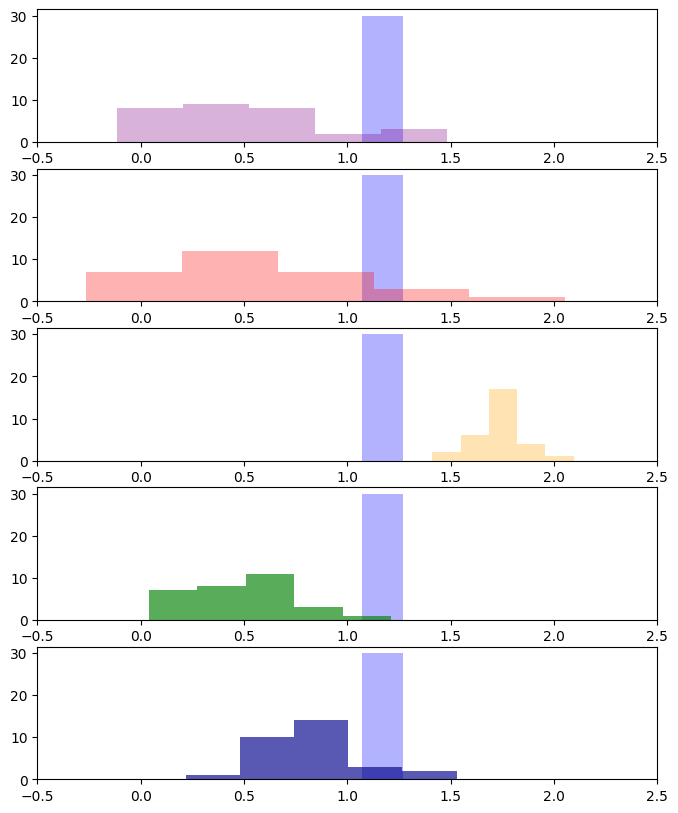

In [22]:
fig, ax = plt.subplots(5,1,figsize=(8,10))
ax[0].hist(result["Ground_truth"], alpha=.3, bins=5, color="blue")
ax[0].hist(result["Eliator"], alpha=.3, bins=5, color="purple")

ax[1].hist(result["Ground_truth"], alpha=.3, bins=5, color="blue")
ax[1].hist(result["Basic_model"], alpha=.3, bins=5, color="red")

ax[2].hist(result["Ground_truth"], alpha=.3, bins=5, color="blue")
ax[2].hist(result["Inf_prior"], alpha=.3, bins=5, color="orange")

ax[3].hist(result["Ground_truth"], alpha=.3, bins=5, color="blue")
ax[3].hist(result["Full_imp"], alpha=.65, bins=5, color="green")

ax[4].hist(result["Ground_truth"], alpha=.3, bins=5, color="blue")
ax[4].hist(result["Full_imp_inf_post"], alpha=.65, bins=5, color="darkblue")

for i in range(5):
    ax[i].set_xlim(-.5, 2.5)

In [166]:
temp_data = simulate_data(bulk_graph, coefficients=cell_coef, 
                            mnar_missing_param=[-3, .3], 
                            add_feature_var=True, n=50, seed=3)

summarized_data = dataProcess(temp_data["Feature_data"], 
                        normalization=False, 
                        feature_selection="All",
                        MBimpute=False,
                        sim_data=True)

transformed_data = normalize(summarized_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]
input_data.head()

simulating data...
adding feature level data...
masking data...


,EGF,IGF,SOS,Ras,PI3K,Akt,Raf,Mek,Erk
0,0.791078,-0.405983,0.286591,-0.884609,2.117343,2.277203,-0.859491,-0.776977,0.036097
1,-0.346715,-0.482662,-0.590223,-1.326594,1.311450,1.349702,-0.710316,-0.343956,0.352195
2,0.333075,-0.246669,-0.060263,-0.889667,2.380294,2.374486,-0.750296,-0.127460,0.626946
3,0.345206,-0.783333,-0.392976,-1.122055,1.599803,1.531715,-0.906905,-0.553431,0.355770
4,0.659419,-0.066250,0.457809,-0.890931,2.681152,2.495513,-0.906962,-0.562060,0.429050


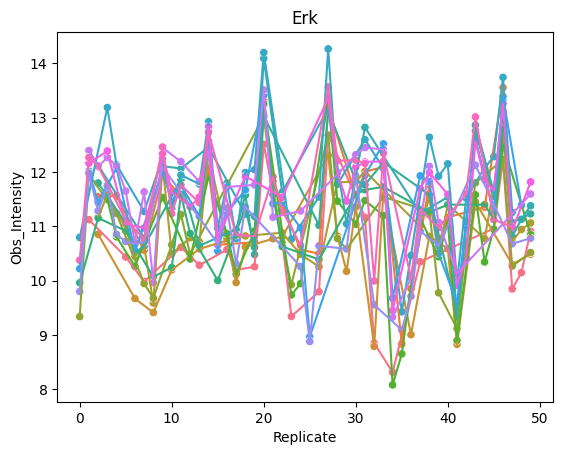

In [167]:
from MScausality.simulation.simulation import simple_profile_plot
# simple_profile_plot(temp_data["Feature_data"], "Erk", intensity_col="Intensity")
simple_profile_plot(temp_data["Feature_data"], "Erk")


In [8]:
# Full imp Bayesian model with informative prior
lvm = LVM(input_data, alt_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.get_priors()

for i in lvm.priors.keys():
    for v in lvm.priors[i].keys():
        if (v != "Raf_Akt_coef") & ("coef" in v): 
            if (lvm.priors[i][v]) < .75:
                lvm.priors[i][v] = 1.
# lvm.priors["Mek"]["Mek_Raf_coef"] = 1.
lvm.priors

pyro.clear_param_store()
lvm.fit_model(num_steps=10000)

# imp_data = lvm.imputed_data
# imp_data.loc[:, "Intensity"] = np.where(imp_data['imp_mean'].isna(), 
#                                         imp_data['intensity'], 
#                                         imp_data['imp_mean'])
# imp_data.loc[:, "index"] = np.tile(
#     range(len(imp_data.loc[imp_data["protein"] == "Ras"])), 
#     len(imp_data["protein"].unique()))
# new_obs_data = imp_data.pivot(index="index", 
#                             columns="protein", 
#                             values="Intensity")

# pyro.clear_param_store()
# lvm = LVM(new_obs_data, int_graph)
# lvm.prepare_graph()
# lvm.prepare_data()
# lvm.get_priors()
# lvm.priors
# lvm.fit_model(num_steps=10000)

Step 0: Loss = 1228.2644812338986
Step 100: Loss = -460.00281646847725
Step 200: Loss = -766.7982955276966
Step 300: Loss = -909.5131578147411
Step 400: Loss = -983.0601010620594
Step 500: Loss = -1030.9338907897472
Step 600: Loss = -1019.1196359097958
Step 700: Loss = -1113.8101945221424
Step 800: Loss = -1167.0026305317879
Step 900: Loss = -1157.3381069600582
Step 1000: Loss = -1169.6338963508606
Step 1100: Loss = -1195.925218373537
Step 1200: Loss = -1204.2184645533562
Step 1300: Loss = -1250.7415586411953
Step 1400: Loss = -1260.3911737501621
Stopping early at step 1473 with loss -1259.7649714052677


In [9]:
lvm.priors

{'SOS': {'SOS_int': -0.33966923, 'SOS_scale': 0.2506825029850006},
 'Ras': {'Ras_SOS_coef': 1.0, 'Ras_int': -0.14878981},
 'PI3K': {'PI3K_Ras_coef': 1.1192188, 'PI3K_int': 1.8012066},
 'Akt': {'Akt_PI3K_coef': 1.0, 'Akt_int': 0.2553565},
 'Raf': {'Raf_Ras_coef': 1.0,
  'Raf_Akt_coef': -0.26458913,
  'Raf_int': -1.0721176},
 'Mek': {'Mek_Raf_coef': 1.0, 'Mek_int': 0.16781878},
 'Erk': {'Erk_Mek_coef': 1.0024639, 'Erk_int': -0.6527549}}

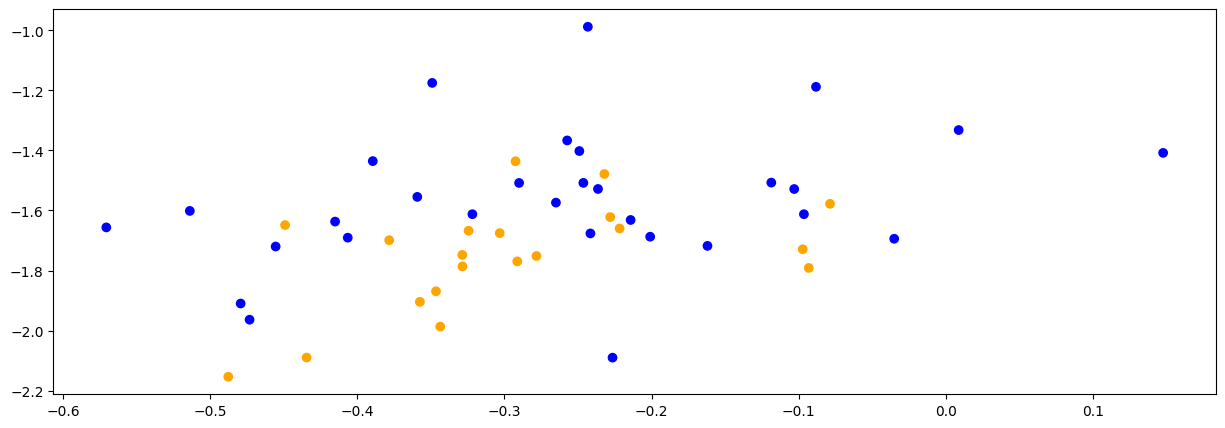

In [10]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
raf_data = imp_data.loc[imp_data["protein"] == "Raf"]
mek_data = imp_data.loc[imp_data["protein"] == "Mek"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((ras_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", "orange"))
raf_mek_backdoor_color = np.where(
    (raf_data['imp_mean'].isna().values & mek_data['imp_mean'].isna().values), 
    "blue", np.where((raf_data['intensity'].isna().values & mek_data['intensity'].isna().values), 
                     "red", "orange"))
mek_erk_backdoor_color = np.where(
    (mek_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((mek_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", "orange"))

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
raf_data = np.where(raf_data['imp_mean'].isna(), raf_data['intensity'], raf_data['imp_mean'])
mek_data = np.where(mek_data['imp_mean'].isna(), mek_data['intensity'], mek_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

# fig, ax = plt.subplots(1,3, figsize=(15,5))
# ax[0].scatter(ras_data, raf_data, color=ras_raf_backdoor_color)
# ax[1].scatter(raf_data, mek_data, color=raf_mek_backdoor_color)
# ax[2].scatter(mek_data, erk_data, color=mek_erk_backdoor_color)

fig, ax = plt.subplots( figsize=(15,5))
ax.scatter(ras_data, erk_data, color=ras_raf_backdoor_color)

# ax.set_xlim(-3,0)

# ax.set_ylim(-3,0)

(-3.0, 1.0)

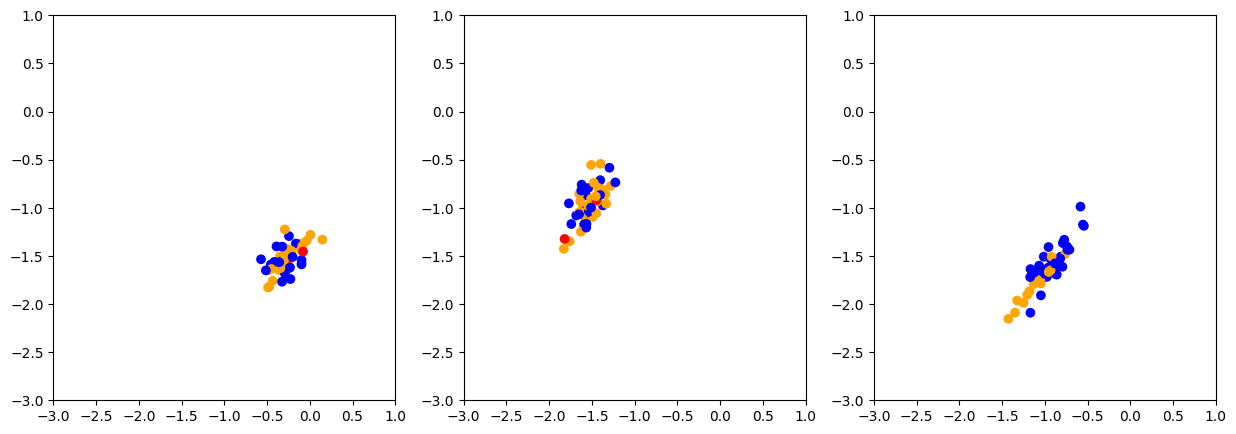

In [11]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
raf_data = imp_data.loc[imp_data["protein"] == "Raf"]
mek_data = imp_data.loc[imp_data["protein"] == "Mek"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & raf_data['imp_mean'].isna().values), 
    "blue", np.where((ras_data['intensity'].isna().values & raf_data['intensity'].isna().values), 
                     "red", "orange"))
raf_mek_backdoor_color = np.where(
    (raf_data['imp_mean'].isna().values & mek_data['imp_mean'].isna().values), 
    "blue", np.where((raf_data['intensity'].isna().values & mek_data['intensity'].isna().values), 
                     "red", "orange"))
mek_erk_backdoor_color = np.where(
    (mek_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((mek_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", "orange"))

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
raf_data = np.where(raf_data['imp_mean'].isna(), raf_data['intensity'], raf_data['imp_mean'])
mek_data = np.where(mek_data['imp_mean'].isna(), mek_data['intensity'], mek_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(ras_data, raf_data, color=ras_raf_backdoor_color)
ax[1].scatter(raf_data, mek_data, color=raf_mek_backdoor_color)
ax[2].scatter(mek_data, erk_data, color=mek_erk_backdoor_color)

ax[0].set_xlim(-3,1)
ax[1].set_xlim(-3,1)
ax[2].set_xlim(-3,1)
ax[0].set_ylim(-3,1)
ax[1].set_ylim(-3,1)
ax[2].set_ylim(-3,1)

In [12]:
full_imp_inf_post_model_ate = intervention(lvm, int1, int2, outcome, scale_metrics)

In [13]:
full_imp_inf_post_model_ate

tensor(0.9795)

## Older stuff

(-3.0, 0.0)

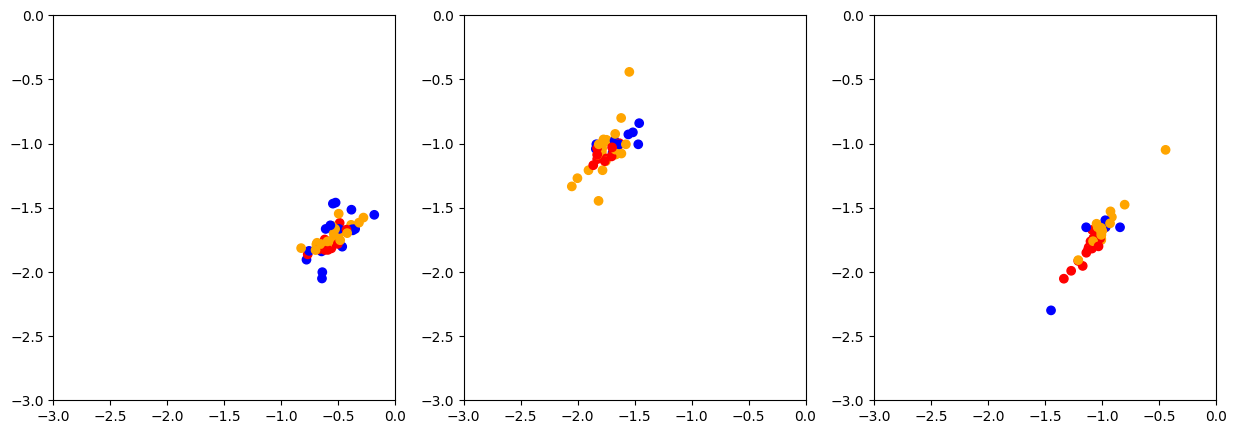

In [106]:
imp_data = lvm.imputed_data

ras_data = imp_data.loc[imp_data["protein"] == "Ras"]
raf_data = imp_data.loc[imp_data["protein"] == "Raf"]
mek_data = imp_data.loc[imp_data["protein"] == "Mek"]
erk_data = imp_data.loc[imp_data["protein"] == "Erk"]

ras_raf_backdoor_color = np.where(
    (ras_data['imp_mean'].isna().values & raf_data['imp_mean'].isna().values), 
    "blue", np.where((ras_data['intensity'].isna().values & raf_data['intensity'].isna().values), 
                     "red", "orange"))
raf_mek_backdoor_color = np.where(
    (raf_data['imp_mean'].isna().values & mek_data['imp_mean'].isna().values), 
    "blue", np.where((raf_data['intensity'].isna().values & mek_data['intensity'].isna().values), 
                     "red", "orange"))
mek_erk_backdoor_color = np.where(
    (mek_data['imp_mean'].isna().values & erk_data['imp_mean'].isna().values), 
    "blue", np.where((mek_data['intensity'].isna().values & erk_data['intensity'].isna().values), 
                     "red", "orange"))

ras_data = np.where(ras_data['imp_mean'].isna(), ras_data['intensity'], ras_data['imp_mean'])
raf_data = np.where(raf_data['imp_mean'].isna(), raf_data['intensity'], raf_data['imp_mean'])
mek_data = np.where(mek_data['imp_mean'].isna(), mek_data['intensity'], mek_data['imp_mean'])
erk_data = np.where(erk_data['imp_mean'].isna(), erk_data['intensity'], erk_data['imp_mean'])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(ras_data, raf_data, color=ras_raf_backdoor_color)
ax[1].scatter(raf_data, mek_data, color=raf_mek_backdoor_color)
ax[2].scatter(mek_data, erk_data, color=mek_erk_backdoor_color)

ax[0].set_xlim(-3,0)
ax[1].set_xlim(-3,0)
ax[2].set_xlim(-3,0)
ax[0].set_ylim(-3,0)
ax[1].set_ylim(-3,0)
ax[2].set_ylim(-3,0)

# Multiple replicate analysis

In [25]:
results = dict()
for i in ["20", "50", "100", "250", "1000"]:
    with open(f"/Users/kohler.d/Downloads/{i}_reps.pkl", "rb") as input_file:
        results[i] = pickle.load(input_file)

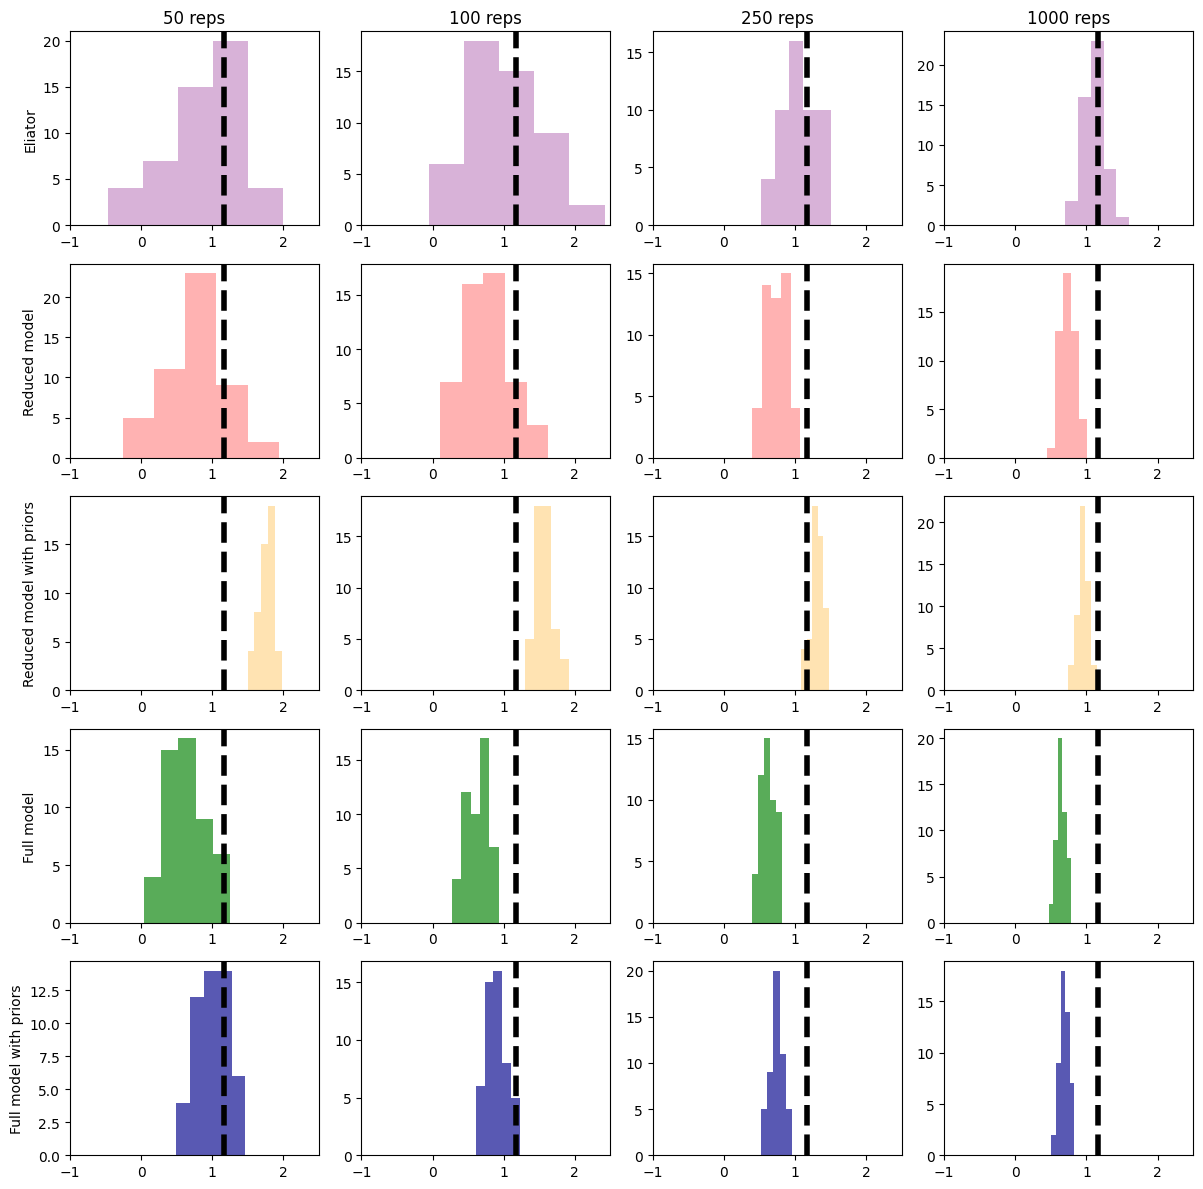

In [54]:
fig, ax = plt.subplots(5,4,figsize=(12,12))

for i in range(4):

    key = ["50", "100", "250", "1000"][i]

    ax[0, i].axvline(results[key].loc[0, "Ground_truth"], 
                     color="black", linestyle="dashed", lw=4)
    ax[0, i].hist(results[key]["Eliator"], alpha=.3, bins=5, color="purple")
    ax[0, i].set_title(f"{key} reps")
    ax[0, 0].set_ylabel("Eliator")

    ax[1, i].axvline(results[key].loc[0, "Ground_truth"], 
                     color="black", linestyle="dashed", lw=4)
    ax[1, i].hist(results[key]["Basic_model"], alpha=.3, bins=5, color="red")
    ax[1, 0].set_ylabel("Reduced model")

    ax[2, i].axvline(results[key].loc[0, "Ground_truth"], 
                     color="black", linestyle="dashed", lw=4)
    ax[2, i].hist(results[key]["Inf_prior"], alpha=.3, bins=5, color="orange")
    ax[2, 0].set_ylabel("Reduced model with priors")

    ax[3, i].axvline(results[key].loc[0, "Ground_truth"], 
                     color="black", linestyle="dashed", lw=4)
    ax[3, i].hist(results[key]["Full_imp"], alpha=.65, bins=5, color="green")
    ax[3, 0].set_ylabel("Full model")

    ax[4, i].axvline(results[key].loc[0, "Ground_truth"], 
                     color="black", linestyle="dashed", lw=4)
    ax[4, i].hist(results[key]["Full_imp_inf_post"], alpha=.65, bins=5, color="darkblue")
    ax[4, 0].set_ylabel("Full model with priors")

# plt.setp(ax, xlim=(-5,5))
plt.setp(ax, xlim=(-1,2.5))
plt.tight_layout()